## Validação dos dados ECG

O objetivo desta etapa é verificar qual o melhor método para a limpeza dos sinais de ECG. Para isso, o sinal passará por várias etapas, buscando alcançar o melhor desempenho possível. Como critério de validação e calibração da limpeza dos sinais, utilizarei quatro métricas principais: HRV_MeanNN, HRV_rmSSD, QRS_duration_média e QT_interval_média. Esses resultados serão verificados para avaliar se estão dentro dos padrões aceitáveis. Além disso, utilizarei valores médios registrados em arquivos CSV de cada paciente como ponto de referência para verificar a conformidade.
A primeira etapa do processo consiste na aplicação de técnicas de wavelet, com o objetivo de remover artefatos que não pertencem ao sinal fisiológico. Em seguida, será realizada uma etapa de limpeza utilizando diferentes algoritmos: Pan-Tompkins (1985), Elgendi (2010), Hamilton (2002), Engzeemod (2012) e filtro Butterworth. Cada um desses métodos passará por um processo de calibração de parâmetros, orientado pela busca dos ajustes que melhor se encaixem ao sinal, utilizando abordagens como pipelines, validação cruzada e otimização bayesiana. Ou seja, a calibração não será totalmente automática, mas sim realizada de forma sistemática, com base em métodos de otimização. Utilizando a biblioteca NeuroKit2, que atualmente se destaca pelos bons resultados em diversas aplicações. No entanto, não se descarta a possibilidade de testar outras bibliotecas ou mesmo implementar procedimentos manuais, caso os resultados não sejam satisfatórios.
Além disso, será empregado um método de otimização para encontrar os melhores parâmetros, utilizando estratégias como pipelines, validação cruzada, otimização bayesiana e outras técnicas que se mostrem mais adequadas durante a pesquisa.
Os dados de ECG utilizados correspondem a registros de Holter de 24 horas. Para a análise, selecionarei um intervalo de 1 hora, posterior à primeira hora do registro, considerando que a frequência de amostragem é de 200 Hz, resultando em 720.000 amostras. Posteriormente, esse intervalo será fragmentado em 60 épocas, cada uma equivalente a 1 minuto.
Para cada uma dessas épocas, serão calculadas as métricas: HRV_MeanNN, HRV_rmSSD, QRS_duration_média e QT_interval_média. O intuito final é gerar um relatório que apresente os melhores resultados obtidos, possibilitando a identificação do método de limpeza que mais se adequa ao propósito da pesquisa.



In [1]:
%%time
import numpy as np
import pandas as pd
import neurokit2 as nk
import logging
from tqdm import tqdm
import duckdb
import logging

import mne

CPU times: total: 4.06 s
Wall time: 6.14 s


In [94]:
#!pip install mne

Relatório 

In [2]:
import neurokit2 as nk
import numpy as np

import pywt
import numpy as np
import logging
from tqdm import tqdm
import duckdb


conn_leitura = duckdb.connect("../01_Dataset/Duckedb/Holter_ECG/1h/banco_ecg.duckdb")

# lista = conn_leitura.execute(f"""
#     SELECT DISTINCT id_paciente 
#     FROM ecg_pacientes 
#     ORDER BY id_paciente;
# """).fetchdf()

df = conn_leitura.execute(f"""
SELECT  sinal_x FROM ecg_pacientes  
WHERE id_paciente = 'P0015';
""").fetchdf()


df['sinal_x'].head()

ecg_signal = df['sinal_x'].values[:12000]  # pega os primeiros 12000 pontos



sampling_rate = 200  # Hz

# ===== Processamento do ECG =====
ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)
signals, info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)

# ===== Picos R =====
r_peaks = info["ECG_R_Peaks"]

# ===== RR intervals (em ms) =====
rr_intervals = np.diff(r_peaks) * (1000 / sampling_rate)

# ===== Estatísticas RR =====
min_rr = np.min(rr_intervals)
max_rr = np.max(rr_intervals)
avg_rr = np.mean(rr_intervals)
rr_range = max_rr - min_rr

# ===== Extras: Longest RR pause =====
longest_rr_pause = max_rr

# ===== Detecção de Bradicardia (frequência < 60 bpm) =====
avg_heart_rate = 60000 / avg_rr
bradycardia = int(avg_heart_rate < 60)

# ===== Variabilidade da frequência cardíaca =====
sdnn = np.std(rr_intervals, ddof=1)
rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
pnn50 = (nn50 / len(rr_intervals)) * 100

# ===== Artefato (%): calculando com ecg_quality =====
quality = nk.ecg_quality(ecg_signal, sampling_rate=sampling_rate)
artifact_burden = np.mean(quality == 0) * 100  # %

# ===== Saída =====
print(f"Minimum RR (ms): {min_rr:.2f}")
print(f"Maximum RR (ms): {max_rr:.2f}")
print(f"Average RR (ms): {avg_rr:.2f}")
print(f"RR Range (ms): {rr_range:.2f}")
print(f"Longest RR pause (ms): {longest_rr_pause:.2f}")
print(f"Bradycardia: {'Yes' if bradycardia else 'No'}")
print(f"SDNN (ms): {sdnn:.2f}")
print(f"RMSSD (ms): {rmssd:.2f}")
print(f"pNN50 (%): {pnn50:.2f}")
print(f"Artifact burden (%): {artifact_burden:.2f}")


Minimum RR (ms): 500.00
Maximum RR (ms): 530.00
Average RR (ms): 520.35
RR Range (ms): 30.00
Longest RR pause (ms): 530.00
Bradycardia: No
SDNN (ms): 8.11
RMSSD (ms): 4.10
pNN50 (%): 0.00
Artifact burden (%): 0.51


In [3]:
tabela_csv = pd.read_csv('../01_Dataset/dados_csv_info_definitions/subject-info_formatado.csv', sep=';')

In [23]:
tabela_csv[tabela_csv['Patient ID'] == 'P0015'][['Average RR (ms)','minimum RR (ms) ','maximum RR (ms)','RR range (ms)','Longest RR pause (ms)','Bradycardia','SDNN (ms)','RMSSD (ms)','pNN50 (%)']]


,Average RR (ms),minimum RR (ms),maximum RR (ms),RR range (ms),Longest RR pause (ms),Bradycardia,SDNN (ms),RMSSD (ms),pNN50 (%)
14,566.0,426.0,706.0,280.0,NaN,0.0,42.0,5.4,0.1


## Fluxo de pré-processamento de ECG

|Fluxo | Etapas | Indicação|
| -------------- | ----------------------------------------------------- | --------------------------------------------------------------- |
|Automático (simples)|	ECG bruto → ecg_clean → ecg_peaks| ✅ Recomendado para quem quer praticidade, com filtros padrão eficientes|
|Manual (personalizado)|	ECG bruto → signal_detrend → signal_filter → ecg_peaks|	✅ Indicado para quem quer ajustar manualmente filtros, ordens, frequências|
|Híbrido (possível, mas não recomendado)|	ECG bruto → signal_detrend → ecg_clean → ecg_peaks|	⚠️ Possível, mas cuidado: pode gerar filtragem redundante ou perda de informações|
|Totalmente bruto (não recomendado)|	ECG bruto → ecg_peaks|	❌ Não recomendado: sem limpeza, detecção de picos R pode ser ruim|


## 1 Teste de validação

In [ ]:
class ECGProcessor:
    def __init__(self,fs=200):
        #self.ecg_limpo = None
        self.fs = fs  # Taxa de amostragem padrão
        self.id_paciente = None  # ID do paciente, se necessário
        

    def epocas(self,sinal_limpo):
        """
        Divide o sinal de ECG limpo em épocas de 60 segundos.
        """
        
        epoch_duration_seconds = 60  # Duração de cada época em segundos
        epoch_length_samples = epoch_duration_seconds * self.fs  # Tamanho da época em amostras

        # Número total de épocas que cabem no sinal
        num_epochs = len(sinal_limpo) // epoch_length_samples

        # Eventos (índices de início de cada época)
        events = [i * epoch_length_samples for i in range(num_epochs)]

        # Criação das épocas usando o NeuroKit
        epochs = nk.epochs_create(sinal_limpo,
                                  events=events,
                                  sampling_rate=self.fs,
                                  epochs_start=0,
                                  epochs_end=60)
        return epochs



 #   def qts(self):
        """
        Calcula duas medidas para cada época:
        - Duração média do complexo QRS (QRS Duration)
        - Intervalo QT corrigido (QTc), usando a fórmula de Bazett
        """
        epochs = self.epocas()

        qrs_duration_media = []
        qt_interval_media = []
        HRV_MeanNN = []
        HRV_rmSSD = []
        epoca = []

        for x in range(1, 61):
            sinal = epochs[f'{x}']['Signal'].values

            # Detecção dos picos R no sinal
            peaks, info = nk.ecg_peaks(sinal, sampling_rate=self.fs)
            
            # Verifica se há batimentos detectados
            if len(info["ECG_R_Peaks"]) == 0:
                print(f"Nenhum R-peak detectado para o paciente {self.id_paciente}. Pulando cálculo do QRS/QT.")
                continue  # Pula para a próxima época
                
            
            
            #==========================================calculo HRV==================================
            """
            Calcula duas métricas de variabilidade da frequência cardíaca (HRV) para cada época:
            - HRV_MeanNN: média dos intervalos NN
            - HRV_RMSSD: raiz quadrada da média dos quadrados das diferenças sucessivas entre intervalos NN
            """
                
            
            hrv_time = nk.hrv_time(peaks, sampling_rate=self.fs, show=False)  # Calcula HRV

            HRV_MeanNN.append(hrv_time['HRV_MeanNN'].values[0])   
            HRV_rmSSD.append(hrv_time['HRV_RMSSD'].values[0]) 
            epoca.append(x)  # Número da época
            
            
            #==========================================calculo dos QTs==================================
        
            # Delineamento das ondas (P, QRS, T) com a transformada wavelet
            delineate, _ = nk.ecg_delineate(sinal, rpeaks=info["ECG_R_Peaks"],
                                            sampling_rate=self.fs, method="dwt")

            # Índices dos picos relevantes
            q_peaks = delineate[delineate["ECG_Q_Peaks"] == 1].index.to_numpy()
            s_peaks = delineate[delineate["ECG_S_Peaks"] == 1].index.to_numpy()
            t_offsets = delineate[delineate["ECG_T_Offsets"] == 1].index.to_numpy()

            # Verifica se há pares suficientes para análise
            if len(q_peaks) == 0 or len(s_peaks) == 0 or len(t_offsets) == 0:
                qrs_duration_media.append(np.nan)
                qt_interval_media.append(np.nan)
                continue

            # Garante que os pares tenham o mesmo tamanho
            min_len_qs = min(len(q_peaks), len(s_peaks))
            min_len_qt = min(len(q_peaks), len(t_offsets))

            q_peaks_qs = q_peaks[:min_len_qs]
            s_peaks_qs = s_peaks[:min_len_qs]
            q_peaks_qt = q_peaks[:min_len_qt]
            t_offsets_qt = t_offsets[:min_len_qt]

            # Seleciona apenas pares válidos (respeitando a ordem no tempo)
            pares_qs = [(q, s) for q, s in zip(q_peaks_qs, s_peaks_qs) if s > q]
            pares_qt = [(q, t) for q, t in zip(q_peaks_qt, t_offsets_qt) if t > q]

            # Cálculo da duração do complexo QRS em milissegundos
            qrs_duration_ms = [(s - q) / self.fs * 1000 for q, s in pares_qs]
            # Cálculo do intervalo QT em milissegundos
            qt_interval_ms = [(t - q) / self.fs * 1000 for q, t in pares_qt]

            # Aplica média apenas se houver pares válidos
            qrs_duration_media.append(np.nanmean(qrs_duration_ms) if len(qrs_duration_ms) > 0 else np.nan)
            qt_interval_media.append(np.nanmean(qt_interval_ms) if len(qt_interval_ms) > 0 else np.nan)

            # Cálculo do intervalo RR médio em segundos
            rr_intervals = np.diff(info["ECG_R_Peaks"]) / self.fs
            rr_medio = np.mean(rr_intervals)

            # Cálculo do QTc (intervalo QT corrigido) usando a fórmula de Bazett
            if len(qt_interval_ms) > 0 and rr_medio > 0:
                qt_c_medio = np.nanmean(qt_interval_ms) / np.sqrt(rr_medio)
            else:
                qt_c_medio = np.nan

            # Substitui o valor do intervalo QT pela versão corrigida (QTc)
            qt_interval_media[-1] = qt_c_medio

        return qrs_duration_media, qt_interval_media, HRV_MeanNN, HRV_rmSSD, epoca
    def qts(self,sinal_limpo):
        """
        Calcula duas medidas para cada época:
        - Duração média do complexo QRS (QRS Duration)
        - Intervalo QT corrigido (QTc), usando a fórmula de Bazett
        """
        epochs = self.epocas(sinal_limpo)

        min_rr_l = []
        max_rr_l = []
        avg_rr_l = []
        rr_range_l = []
        longest_rr_pause_l = []
        bradycardia_l = []
        sdnn_l = []
        rmssd_l = []
        pnn50_l = []
        artifact_burden_l = []
        epoca = []
    
    

        for x in range(1, 61):
            sinal = epochs[f'{x}']['Signal'].values

            signals, info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)

            # ===== Picos R =====
            r_peaks = info["ECG_R_Peaks"]

            # ===== RR intervals (em ms) =====
            rr_intervals = np.diff(r_peaks) * (1000 / sampling_rate)

            # ===== Estatísticas RR =====
            min_rr = np.min(rr_intervals)
            max_rr = np.max(rr_intervals)
            avg_rr = np.mean(rr_intervals)
            rr_range = max_rr - min_rr

            # ===== Extras: Longest RR pause =====
            longest_rr_pause = max_rr

            # ===== Detecção de Bradicardia (frequência < 60 bpm) =====
            avg_heart_rate = 60000 / avg_rr
            bradycardia = int(avg_heart_rate < 60)

            # ===== Variabilidade da frequência cardíaca =====
            sdnn = np.std(rr_intervals, ddof=1)
            rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
            nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
            pnn50 = (nn50 / len(rr_intervals)) * 100

            # ===== Artefato (%): calculando com ecg_quality =====
            quality = nk.ecg_quality(ecg_signal, sampling_rate=sampling_rate)
            artifact_burden = np.mean(quality == 0) * 100  # %
            
            epoca.append(x)  # Número da época
            min_rr_l.append(min_rr)
            max_rr_l.append(max_rr)
            avg_rr_l.append(avg_rr)
            rr_range_l.append(rr_range)
            longest_rr_pause_l.append(longest_rr_pause)
            bradycardia_l.append(bradycardia)  
            sdnn_l.append(sdnn)
            rmssd_l.append(rmssd)
            pnn50_l.append(pnn50)
            artifact_burden_l.append(artifact_burden)

        return min_rr_l, max_rr_l, avg_rr_l, rr_range_l, longest_rr_pause_l, bradycardia_l, sdnn_l, rmssd_l, pnn50_l, artifact_burden_l, epoca


    
# 1 Fase   ================================================================================
 
    # 1 Etapa para tirar atefatos bem suaveis
    def wavelet_filter_preservando_qrs(self, signal, wavelet='db6', level=4, atenuacao=0.2):
        coeffs = pywt.wavedec(signal, wavelet, level=level) # menos agressivo

        # Mantém detalhes de nível 1 e 2 (alta frequência = QRS)
        for i in range(3, len(coeffs)):  # Atenua detalhes de nível mais alto
            coeffs[i] *= atenuacao # mantém 20% da energia

        ecg_wavelet_filtered = pywt.waverec(coeffs, wavelet)
        return ecg_wavelet_filtered
    
    # 2 Etapa filtoragem do sinal

    
# 2 Fase   ================================================================================
# Sera usada outra classe para processamento de ECG que sera a segunda etapa do processamento
# onde vai ser o signal_detrend e signal_filter do neurokit em vez de ecg_clear

    def process(self, signal):
        """
        Função principal de processamento.
        Limpa o sinal, calcula as métricas HRV, QRS e QTc, e retorna um DataFrame com os resultados.
        """
        
        dfs = []  # Lista para armazenar DataFrames de cada método
        #self.signal = signal
    
        
        #teste2
        # Por exemplo: preserve cD1 e cD2
        # zera só os detalhes de níveis mais altos
        ecg_wavelet_filtered = self.wavelet_filter_preservando_qrs(signal, wavelet='db6', level=2, atenuacao=0.2)
        
        
        # Lista de métodos de limpeza do NeuroKit a serem testados
        metodos = ["neurokit", "biosppy", "pantompkins1985", "hamilton2002", "elgendi2010", "engzeemod2012", "vg"]
        
        
        for metodo in metodos:
            # Limpeza do sinal com o método de Pan-Tompkins
            ecg_limpo = nk.ecg_clean(ecg_wavelet_filtered, sampling_rate= self.fs, method=metodo)
            

            # Ajuste de escala (opcional): desloca o sinal para cima, garantindo valores positivos
            # self.ecg_limpo = ecg_limpo + 2
            #self.ecg_limpo = ecg_limpo

            # Cálculo das métricas QRS de QTc e HRV
            min_rr_l, max_rr_l, avg_rr_l, rr_range_l, longest_rr_pause_l, bradycardia_l, sdnn_l, rmssd_l, pnn50_l, artifact_burden_l, epoca = self.qts(ecg_limpo)
            
            df = pd.DataFrame({
                'Epoca': epoca,
                'Metodo':metodo,
                'Average RR (ms)': avg_rr_l,
                'minimum RR (ms)': min_rr_l,
                'maximum RR (ms)': max_rr_l,
                'RR range (ms)': rr_range_l,
                'Longest RR pause (ms)': longest_rr_pause_l,
                'Bradycardia': bradycardia_l,
                'SDNN (ms)': sdnn_l,
                'RMSSD (ms)': rmssd_l,
                'pNN50 (%)': pnn50_l,
                'Artifact burden (%)': artifact_burden_l
                
            })
            
            dfs.append(df)  # Adiciona o DataFrame à lista


        return pd.concat(dfs, ignore_index=True)
# ssss

IndentationError: unexpected indent (1403463084.py, line 2)

In [ ]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import pywt
import time
from datetime import datetime

class ECGProcessor:
    def __init__(self, fs=200):
        self.fs = fs  
        self.id_paciente = None  
        self.log_entries = []  # Lista para armazenar entradas de log
        
    def _log(self, level, message, epoca=None, metodo=None, duration=None):
        """Adiciona entrada ao log"""
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]
        self.log_entries.append({
            'timestamp': timestamp,
            'level': level,
            'epoca': epoca,
            'metodo': metodo,
            'duration_seconds': duration,
            'message': message
        })
        
    def get_log_df(self):
        """Retorna log como DataFrame"""
        return pd.DataFrame(self.log_entries)
        
    def clear_log(self):
        """Limpa o log"""
        self.log_entries = []
        
    def epocas(self, sinal_limpo):
        """
        Divide o sinal de ECG limpo em épocas de 60 segundos.
        """
        start_time = time.time()
        
        epoch_duration_seconds = 60 
        epoch_length_samples = epoch_duration_seconds * self.fs  

        self._log('INFO', f"Sinal total: {len(sinal_limpo)} amostras")
        self._log('INFO', f"Tamanho da época: {epoch_length_samples} amostras ({epoch_duration_seconds}s)")

        # Número total de épocas que cabem no sinal
        num_epochs = len(sinal_limpo) // epoch_length_samples
        self._log('INFO', f"Número de épocas possíveis: {num_epochs}")

        # Eventos (índices de início de cada época)
        events = [i * epoch_length_samples for i in range(num_epochs)]
        events_str = f"{events[:5]}..." if len(events) > 5 else f"{events}"
        self._log('INFO', f"Eventos (índices de início): {events_str}")

        # Criação das épocas usando o NeuroKit
        epochs = nk.epochs_create(sinal_limpo,
                                  events=events,
                                  sampling_rate=self.fs,
                                  epochs_start=0,
                                  epochs_end=60)
        
        self._log('INFO', f"Épocas criadas: {list(epochs.keys())}")
        
        # Verificar se as épocas são diferentes
        if len(epochs) > 1:
            epoch1 = epochs['1']['Signal'].values
            epoch2 = epochs['2']['Signal'].values
            self._log('DEBUG', f"Época 1 - média: {np.mean(epoch1):.6f}, std: {np.std(epoch1):.6f}")
            self._log('DEBUG', f"Época 2 - média: {np.mean(epoch2):.6f}, std: {np.std(epoch2):.6f}")
            self._log('DEBUG', f"Épocas são diferentes: {not np.array_equal(epoch1, epoch2)}")
        
        duration = time.time() - start_time
        self._log('INFO', f"Criação de épocas concluída", duration=duration)
        
        return epochs

    def qts(self, sinal_limpo, metodo):
        """
        Calcula métricas de ECG para cada época de 60 segundos.
        Preenche com NaN quando não consegue processar uma época.
        """
        start_time = time.time()
        epochs = self.epocas(sinal_limpo)
        num_epochs = len(epochs)
        
        self._log('INFO', f"Processando {num_epochs} épocas para método {metodo}", metodo=metodo)
        
        # Inicialização das listas para armazenar resultados
        min_rr_l = []
        max_rr_l = []
        avg_rr_l = []
        rr_range_l = []
        longest_rr_pause_l = []
        bradycardia_l = []
        sdnn_l = []
        rmssd_l = []
        pnn50_l = []
        artifact_burden_l = []
        epoca = []

        for x in range(1, num_epochs + 1):
            epoch_start_time = time.time()
            
            try:
                # Extração do sinal da época
                epoch_key = str(x)  
                if epoch_key not in epochs:
                    self._log('WARNING', f"Época {epoch_key} não encontrada", epoca=x, metodo=metodo)
                    # Preenche com NaN em vez de pular
                    epoca.append(x)
                    min_rr_l.append(np.nan)
                    max_rr_l.append(np.nan)
                    avg_rr_l.append(np.nan)
                    rr_range_l.append(np.nan)
                    longest_rr_pause_l.append(np.nan)
                    bradycardia_l.append(np.nan)
                    sdnn_l.append(np.nan)
                    rmssd_l.append(np.nan)
                    pnn50_l.append(np.nan)
                    artifact_burden_l.append(np.nan)
                    continue
                    
                sinal = epochs[epoch_key]['Signal'].values
                self._log('DEBUG', f"Processando sinal com {len(sinal)} amostras", epoca=x, metodo=metodo)
                
                # Detecção de picos R
                peaks, info = nk.ecg_peaks(sinal, sampling_rate=self.fs)
                r_peaks = info["ECG_R_Peaks"]
                
                self._log('DEBUG', f"Detectados {len(r_peaks)} picos R", epoca=x, metodo=metodo)
                
                # Verificação se há picos R suficientes
                if len(r_peaks) < 2:
                    self._log('WARNING', f"Poucos R-peaks detectados ({len(r_peaks)})", epoca=x, metodo=metodo)
                    # Preenche com NaN em vez de pular
                    epoca.append(x)
                    min_rr_l.append(np.nan)
                    max_rr_l.append(np.nan)
                    avg_rr_l.append(np.nan)
                    rr_range_l.append(np.nan)
                    longest_rr_pause_l.append(np.nan)
                    bradycardia_l.append(np.nan)
                    sdnn_l.append(np.nan)
                    rmssd_l.append(np.nan)
                    pnn50_l.append(np.nan)
                    artifact_burden_l.append(np.nan)
                    continue

                # RR intervals (em ms)
                rr_intervals = np.diff(r_peaks) * (1000 / self.fs)
                
                self._log('DEBUG', f"Intervalos RR originais - min: {np.min(rr_intervals):.2f}ms, max: {np.max(rr_intervals):.2f}ms", epoca=x, metodo=metodo)
                
                # Filtrar intervalos RR muito extremos
                valid_rr = rr_intervals[(rr_intervals > 100) & (rr_intervals < 2000)]
                
                if len(valid_rr) == 0:
                    self._log('WARNING', f"Nenhum intervalo RR válido", epoca=x, metodo=metodo)
                    # Preenche com NaN em vez de pular
                    epoca.append(x)
                    min_rr_l.append(np.nan)
                    max_rr_l.append(np.nan)
                    avg_rr_l.append(np.nan)
                    rr_range_l.append(np.nan)
                    longest_rr_pause_l.append(np.nan)
                    bradycardia_l.append(np.nan)
                    sdnn_l.append(np.nan)
                    rmssd_l.append(np.nan)
                    pnn50_l.append(np.nan)
                    artifact_burden_l.append(np.nan)
                    continue

                self._log('DEBUG', f"{len(valid_rr)} intervalos RR válidos de {len(rr_intervals)} totais", epoca=x, metodo=metodo)

                # Estatísticas RR
                min_rr = np.min(valid_rr)
                max_rr = np.max(valid_rr)
                avg_rr = np.mean(valid_rr)
                rr_range = max_rr - min_rr

                # Longest RR pause
                longest_rr_pause = max_rr

                # Detecção de Bradicardia
                avg_heart_rate = 60000 / avg_rr
                bradycardia = int(avg_heart_rate < 60)

                # Variabilidade da frequência cardíaca
                sdnn = np.std(valid_rr, ddof=1)
                
                # RMSSD
                if len(valid_rr) > 1:
                    rmssd = np.sqrt(np.mean(np.diff(valid_rr) ** 2))
                else:
                    rmssd = np.nan
                
                # pNN50
                if len(valid_rr) > 1:
                    nn50 = np.sum(np.abs(np.diff(valid_rr)) > 50)
                    pnn50 = (nn50 / (len(valid_rr) - 1)) * 100
                else:
                    pnn50 = 0

                # Artefato (%)
                try:
                    quality = nk.ecg_quality(sinal, sampling_rate=self.fs)
                    if hasattr(quality, '__len__'):
                        artifact_burden = (1 - np.mean(quality)) * 100
                    else:
                        artifact_burden = (1 - quality) * 100 if quality < 1 else 0
                except Exception as quality_error:
                    self._log('WARNING', f"Erro no cálculo de qualidade: {quality_error}", epoca=x, metodo=metodo)
                    try:
                        normalized_signal = (sinal - np.mean(sinal)) / np.std(sinal)
                        artifacts = np.abs(normalized_signal) > 3
                        artifact_burden = np.mean(artifacts) * 100
                    except:
                        artifact_burden = 0

                self._log('DEBUG', f"avg_rr={avg_rr:.2f}, sdnn={sdnn:.2f}, rmssd={rmssd:.2f}", epoca=x, metodo=metodo)

                # Armazenar resultados
                epoca.append(x)
                min_rr_l.append(min_rr)
                max_rr_l.append(max_rr)
                avg_rr_l.append(avg_rr)
                rr_range_l.append(rr_range)
                longest_rr_pause_l.append(longest_rr_pause)
                bradycardia_l.append(bradycardia)  
                sdnn_l.append(sdnn)
                rmssd_l.append(rmssd)
                pnn50_l.append(pnn50)
                artifact_burden_l.append(artifact_burden)

            except Exception as e:
                self._log('ERROR', f"Erro na época {x}: {str(e)}", epoca=x, metodo=metodo)
                # Preenche com NaN em vez de pular
                epoca.append(x)
                min_rr_l.append(np.nan)
                max_rr_l.append(np.nan)
                avg_rr_l.append(np.nan)
                rr_range_l.append(np.nan)
                longest_rr_pause_l.append(np.nan)
                bradycardia_l.append(np.nan)
                sdnn_l.append(np.nan)
                rmssd_l.append(np.nan)
                pnn50_l.append(np.nan)
                artifact_burden_l.append(np.nan)
            
            # Log do tempo da época
            epoch_duration = time.time() - epoch_start_time
            self._log('DEBUG', f"Época processada", epoca=x, metodo=metodo, duration=epoch_duration)

        duration = time.time() - start_time
        self._log('INFO', f"Processamento de {len(epoca)} épocas concluído", metodo=metodo, duration=duration)
        
        return (min_rr_l, max_rr_l, avg_rr_l, rr_range_l, longest_rr_pause_l, 
                bradycardia_l, sdnn_l, rmssd_l, pnn50_l, artifact_burden_l, epoca)

    def wavelet_filter_preservando_qrs(self, signal, wavelet='db6', level=4, atenuacao=0.2):
        """
        Aplica filtro wavelet preservando características do complexo QRS.
        """
        start_time = time.time()
        
        if signal.ndim > 1:
            signal = signal.flatten()
            
        coeffs = pywt.wavedec(signal, wavelet, level=level)

        for i in range(3, len(coeffs)):
            coeffs[i] *= atenuacao

        ecg_wavelet_filtered = pywt.waverec(coeffs, wavelet)
        
        if len(ecg_wavelet_filtered) > len(signal):
            ecg_wavelet_filtered = ecg_wavelet_filtered[:len(signal)]
        
        duration = time.time() - start_time
        self._log('INFO', f"Filtro wavelet aplicado", duration=duration)
        
        return ecg_wavelet_filtered
    
    def process(self, signal):
        """
        Função principal de processamento.
        """
        total_start_time = time.time()
        
        self._log('INFO', f"Iniciando processamento do sinal: {len(signal)} amostras")
        self._log('DEBUG', f"Sinal original - média: {np.mean(signal):.6f}, std: {np.std(signal):.6f}")
        
        dfs = []
        
        # Filtro wavelet
        try:
            ecg_wavelet_filtered = self.wavelet_filter_preservando_qrs(
                signal, wavelet='db6', level=2, atenuacao=0.2
            )
            self._log('DEBUG', f"Após filtro wavelet - média: {np.mean(ecg_wavelet_filtered):.6f}, std: {np.std(ecg_wavelet_filtered):.6f}")
        except Exception as e:
            self._log('ERROR', f"Erro no filtro wavelet: {e}")
            ecg_wavelet_filtered = signal
        
        # Métodos de limpeza
        metodos = ["neurokit", "biosppy", "pantompkins1985", "hamilton2002", 
                  "elgendi2010", "engzeemod2012"]
        
        for metodo in metodos:
            method_start_time = time.time()
            
            try:
                self._log('INFO', f"Processando método: {metodo}", metodo=metodo)
                
                # Limpeza do sinal
                ecg_limpo = nk.ecg_clean(ecg_wavelet_filtered, sampling_rate=self.fs, method=metodo)
                #ecg_limpo = nk.ecg_clean(signal, sampling_rate=self.fs, method=metodo)
                
                self._log('DEBUG', f"Após limpeza - média: {np.mean(ecg_limpo):.6f}, std: {np.std(ecg_limpo):.6f}", metodo=metodo)
                
                is_different = not np.allclose(ecg_limpo, ecg_wavelet_filtered, rtol=1e-10)
                self._log('DEBUG', f"Sinal foi modificado pela limpeza: {is_different}", metodo=metodo)
                
                # Cálculo das métricas
                results = self.qts(ecg_limpo, metodo)
                (min_rr_l, max_rr_l, avg_rr_l, rr_range_l, longest_rr_pause_l, 
                 bradycardia_l, sdnn_l, rmssd_l, pnn50_l, artifact_burden_l, epoca) = results
                
                self._log('INFO', f"Método processado: {len(epoca)} épocas", metodo=metodo)
                
                if len(epoca) > 0:
                    avg_preview = avg_rr_l[:3] if len(avg_rr_l) > 2 else avg_rr_l
                    self._log('DEBUG', f"Primeiros valores avg_rr: {avg_preview}", metodo=metodo)
                
                # Criação do DataFrame
                df = pd.DataFrame({
                    'Epoca': epoca,
                    'Metodo': metodo,
                    'Average RR (ms)': avg_rr_l,
                    'minimum RR (ms)': min_rr_l,
                    'maximum RR (ms)': max_rr_l,
                    'RR range (ms)': rr_range_l,
                    'Longest RR pause (ms)': longest_rr_pause_l,
                    'Bradycardia': bradycardia_l,
                    'SDNN (ms)': sdnn_l,
                    'RMSSD (ms)': rmssd_l,
                    'pNN50 (%)': pnn50_l,
                    'Artifact burden (%)': artifact_burden_l
                })
                
                dfs.append(df)
                
            except Exception as e:
                self._log('ERROR', f"Erro no método {metodo}: {str(e)}", metodo=metodo)
                continue
            
            method_duration = time.time() - method_start_time
            self._log('INFO', f"Método {metodo} concluído", metodo=metodo, duration=method_duration)

        # Finalização
        if dfs:
            final_df = pd.concat(dfs, ignore_index=True)
            self._log('INFO', f"DataFrame final: {len(final_df)} linhas")
            self._log('DEBUG', f"Average RR único valores: {final_df['Average RR (ms)'].nunique()}")
            self._log('DEBUG', f"SDNN único valores: {final_df['SDNN (ms)'].nunique()}")
            
            total_duration = time.time() - total_start_time
            self._log('INFO', f"Processamento total concluído", duration=total_duration)
            
            return final_df
        else:
            self._log('ERROR', "Nenhum método foi processado com sucesso")
            return pd.DataFrame()

# Exemplo de uso:
# processor = ECGProcessor(fs=200)
# results_df = processor.process(ecg_signal)
# log_df = processor.get_log_df()
# 
# # Salvar logs
# log_df.to_csv('processing_log.csv', index=False)
# 
# # Analisar tempos de processamento
# timing_summary = log_df[log_df['duration_seconds'].notna()].groupby(['metodo', 'level']).agg({
#     'duration_seconds': ['mean', 'sum', 'count']
# }).round(3)

In [4]:
# usando 
import numpy as np
import pandas as pd
import neurokit2 as nk
import pywt
import time
from datetime import datetime
from typing import Tuple, List, Dict, Optional
import warnings

class ECGProcessor:
    def __init__(self, fs: int = 200, epoch_duration: int = 60):
        """
        Initialize ECG Processor
        
        Parameters:
        -----------
        fs : int
            Sampling frequency in Hz
        epoch_duration : int
            Duration of each epoch in seconds
        """
        self.fs = fs  
        self.epoch_duration = epoch_duration
        self.id_paciente = None  
        self.log_entries = []
        
        # Quality thresholds
        self.rr_min_threshold = 100  # ms
        self.rr_max_threshold = 2000  # ms
        self.min_peaks_threshold = 2
        
    def _log(self, level: str, message: str, epoca: Optional[int] = None, 
             metodo: Optional[str] = None, duration: Optional[float] = None):
        """Add entry to log with improved structure"""
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]
        self.log_entries.append({
            'timestamp': timestamp,
            'level': level,
            'epoca': epoca,
            'metodo': metodo,
            'duration_seconds': duration,
            'message': message
        })
        
    def get_log_df(self) -> pd.DataFrame:
        """Return log as DataFrame"""
        return pd.DataFrame(self.log_entries)
        
    def clear_log(self):
        """Clear the log"""
        self.log_entries = []
        
    def get_processing_summary(self) -> Dict:
        """Get summary statistics from processing log"""
        log_df = self.get_log_df()
        if log_df.empty:
            return {}
            
        timing_data = log_df[log_df['duration_seconds'].notna()]
        
        summary = {
            'total_epochs_processed': len(log_df[log_df['epoca'].notna()]),
            'methods_used': log_df['metodo'].dropna().unique().tolist(),
            'total_processing_time': timing_data['duration_seconds'].sum(),
            'average_epoch_time': timing_data.groupby('metodo')['duration_seconds'].mean().to_dict(),
            'error_count': len(log_df[log_df['level'] == 'ERROR']),
            'warning_count': len(log_df[log_df['level'] == 'WARNING'])
        }
        
        return summary
        
    def epocas(self, sinal_limpo: np.ndarray) -> Dict:
        """
        Divide the cleaned ECG signal into epochs.
        
        Parameters:
        -----------
        sinal_limpo : np.ndarray
            Cleaned ECG signal
            
        Returns:
        --------
        Dict : Dictionary containing epochs
        """
        start_time = time.time()
        
        epoch_length_samples = self.epoch_duration * self.fs

        self._log('INFO', f"Signal length: {len(sinal_limpo)} samples")
        self._log('INFO', f"Epoch size: {epoch_length_samples} samples ({self.epoch_duration}s)")

        num_epochs = len(sinal_limpo) // epoch_length_samples
        self._log('INFO', f"Number of possible epochs: {num_epochs}")

        if num_epochs == 0:
            self._log('WARNING', "Signal too short for any epochs")
            return {}

        events = [i * epoch_length_samples for i in range(num_epochs)]
        events_str = f"{events[:5]}..." if len(events) > 5 else f"{events}"
        self._log('INFO', f"Event indices: {events_str}")

        try:
            epochs = nk.epochs_create(sinal_limpo,
                                      events=events,
                                      sampling_rate=self.fs,
                                      epochs_start=0,
                                      epochs_end=self.epoch_duration)
        except Exception as e:
            self._log('ERROR', f"Failed to create epochs: {e}")
            return {}
        
        self._log('INFO', f"Epochs created: {list(epochs.keys())}")
        
        # Verify epoch differences for debugging
        if len(epochs) > 1:
            epoch1 = epochs['1']['Signal'].values
            epoch2 = epochs['2']['Signal'].values
            self._log('DEBUG', f"Epoch 1 - mean: {np.mean(epoch1):.6f}, std: {np.std(epoch1):.6f}")
            self._log('DEBUG', f"Epoch 2 - mean: {np.mean(epoch2):.6f}, std: {np.std(epoch2):.6f}")
            self._log('DEBUG', f"Epochs are different: {not np.array_equal(epoch1, epoch2)}")
        
        duration = time.time() - start_time
        self._log('INFO', f"Epoch creation completed", duration=duration)
        
        return epochs

    def _calculate_hrv_metrics(self, rr_intervals: np.ndarray) -> Dict:
        """
        Calculate HRV metrics from RR intervals
        
        Parameters:
        -----------
        rr_intervals : np.ndarray
            RR intervals in milliseconds
            
        Returns:
        --------
        Dict : Dictionary containing HRV metrics
        """
        if len(rr_intervals) == 0:
            return {k: np.nan for k in ['sdnn', 'rmssd', 'pnn50']}
        
        # SDNN (Standard deviation of NN intervals)
        sdnn = np.std(rr_intervals, ddof=1)
        
        # RMSSD (Root mean square of successive differences)
        if len(rr_intervals) > 1:
            rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
            
            # pNN50 (Percentage of successive RR intervals that differ by >50ms)
            nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
            pnn50 = (nn50 / (len(rr_intervals) - 1)) * 100
        else:
            rmssd = np.nan
            pnn50 = 0
            
        return {'sdnn': sdnn, 'rmssd': rmssd, 'pnn50': pnn50}

    def _estimate_artifact_burden(self, signal: np.ndarray) -> float:
        """
        Estimate artifact burden in the signal
        
        Parameters:
        -----------
        signal : np.ndarray
            ECG signal
            
        Returns:
        --------
        float : Artifact burden percentage
        """
        try:
            quality = nk.ecg_quality(signal, sampling_rate=self.fs)
            if hasattr(quality, '__len__'):
                artifact_burden = (1 - np.mean(quality)) * 100
            else:
                artifact_burden = (1 - quality) * 100 if quality < 1 else 0
        except Exception:
            # Fallback method: identify outliers as artifacts
            try:
                normalized_signal = (signal - np.mean(signal)) / np.std(signal)
                artifacts = np.abs(normalized_signal) > 3
                artifact_burden = np.mean(artifacts) * 100
            except Exception:
                artifact_burden = 0
                
        return max(0, min(100, artifact_burden))  # Clamp between 0-100%

    def qts(self, sinal_limpo: np.ndarray, metodo: str) -> Tuple:
        """
        Calculate ECG metrics for each epoch.
        
        Parameters:
        -----------
        sinal_limpo : np.ndarray
            Cleaned ECG signal
        metodo : str
            Method name for logging
            
        Returns:
        --------
        Tuple : Tuple containing all calculated metrics
        """
        start_time = time.time()
        epochs = self.epocas(sinal_limpo)
        num_epochs = len(epochs)
        
        if num_epochs == 0:
            self._log('ERROR', f"No epochs available for method {metodo}", metodo=metodo)
            return tuple([[] for _ in range(11)])  # Return empty lists for all metrics
        
        self._log('INFO', f"Processing {num_epochs} epochs for method {metodo}", metodo=metodo)
        
        # Initialize result containers
        results = {
            'min_rr': [], 'max_rr': [], 'avg_rr': [], 'rr_range': [],
            'longest_rr_pause': [], 'bradycardia': [], 'sdnn': [],
            'rmssd': [], 'pnn50': [], 'artifact_burden': [], 'epoca': []
        }

        for x in range(1, num_epochs + 1):
            epoch_start_time = time.time()
            
            try:
                epoch_key = str(x)  
                if epoch_key not in epochs:
                    self._log('WARNING', f"Epoch {epoch_key} not found", epoca=x, metodo=metodo)
                    self._append_nan_results(results, x)
                    continue
                    
                signal = epochs[epoch_key]['Signal'].values
                self._log('DEBUG', f"Processing signal with {len(signal)} samples", epoca=x, metodo=metodo)
                
                # Peak detection
                peaks, info = nk.ecg_peaks(signal, sampling_rate=self.fs)
                r_peaks = info["ECG_R_Peaks"]
                
                self._log('DEBUG', f"Detected {len(r_peaks)} R-peaks", epoca=x, metodo=metodo)
                
                if len(r_peaks) < self.min_peaks_threshold:
                    self._log('WARNING', f"Insufficient R-peaks detected ({len(r_peaks)})", epoca=x, metodo=metodo)
                    self._append_nan_results(results, x)
                    continue

                # Calculate RR intervals
                rr_intervals = np.diff(r_peaks) * (1000 / self.fs)
                
                self._log('DEBUG', f"Original RR intervals - min: {np.min(rr_intervals):.2f}ms, max: {np.max(rr_intervals):.2f}ms", epoca=x, metodo=metodo)
                
                # Filter extreme RR intervals
                valid_rr = rr_intervals[
                    (rr_intervals > self.rr_min_threshold) & 
                    (rr_intervals < self.rr_max_threshold)
                ]
                
                if len(valid_rr) == 0:
                    self._log('WARNING', f"No valid RR intervals", epoca=x, metodo=metodo)
                    self._append_nan_results(results, x)
                    continue

                self._log('DEBUG', f"{len(valid_rr)} valid RR intervals from {len(rr_intervals)} total", epoca=x, metodo=metodo)

                # Basic RR statistics
                min_rr = np.min(valid_rr)
                max_rr = np.max(valid_rr)
                avg_rr = np.mean(valid_rr)
                rr_range = max_rr - min_rr
                longest_rr_pause = max_rr

                # Bradycardia detection
                avg_heart_rate = 60000 / avg_rr
                bradycardia = int(avg_heart_rate < 60)

                # HRV metrics
                hrv_metrics = self._calculate_hrv_metrics(valid_rr)

                # Artifact burden
                artifact_burden = self._estimate_artifact_burden(signal)

                self._log('DEBUG', f"avg_rr={avg_rr:.2f}, sdnn={hrv_metrics['sdnn']:.2f}, rmssd={hrv_metrics['rmssd']:.2f}", epoca=x, metodo=metodo)

                # Store results
                results['epoca'].append(x)
                results['min_rr'].append(min_rr)
                results['max_rr'].append(max_rr)
                results['avg_rr'].append(avg_rr)
                results['rr_range'].append(rr_range)
                results['longest_rr_pause'].append(longest_rr_pause)
                results['bradycardia'].append(bradycardia)
                results['sdnn'].append(hrv_metrics['sdnn'])
                results['rmssd'].append(hrv_metrics['rmssd'])
                results['pnn50'].append(hrv_metrics['pnn50'])
                results['artifact_burden'].append(artifact_burden)

            except Exception as e:
                self._log('ERROR', f"Error in epoch {x}: {str(e)}", epoca=x, metodo=metodo)
                self._append_nan_results(results, x)
            
            # Log epoch processing time
            epoch_duration = time.time() - epoch_start_time
            self._log('DEBUG', f"Epoch processed", epoca=x, metodo=metodo, duration=epoch_duration)

        duration = time.time() - start_time
        self._log('INFO', f"Processing of {len(results['epoca'])} epochs completed", metodo=metodo, duration=duration)
        
        return (results['min_rr'], results['max_rr'], results['avg_rr'], 
                results['rr_range'], results['longest_rr_pause'], results['bradycardia'],
                results['sdnn'], results['rmssd'], results['pnn50'], 
                results['artifact_burden'], results['epoca'])

    def _append_nan_results(self, results: Dict, epoca: int):
        """Helper function to append NaN values for failed epochs"""
        results['epoca'].append(epoca)
        for key in results:
            if key != 'epoca':
                results[key].append(np.nan)

    def wavelet_filter_preservando_qrs(self, signal: np.ndarray, wavelet: str = 'db6', 
                                       level: int = 4, atenuacao: float = 0.2) -> np.ndarray:
        """
        Apply wavelet filter preserving QRS characteristics.
        
        Parameters:
        -----------
        signal : np.ndarray
            Input ECG signal
        wavelet : str
            Wavelet type
        level : int
            Decomposition level
        atenuacao : float
            Attenuation factor for high-frequency components
            
        Returns:
        --------
        np.ndarray : Filtered signal
        """
        start_time = time.time()
        
        if signal.ndim > 1:
            signal = signal.flatten()
            
        try:
            coeffs = pywt.wavedec(signal, wavelet, level=level)

            # Attenuate high-frequency components while preserving QRS
            for i in range(3, len(coeffs)):
                coeffs[i] *= atenuacao

            ecg_wavelet_filtered = pywt.waverec(coeffs, wavelet)
            
            # Ensure same length as input
            if len(ecg_wavelet_filtered) > len(signal):
                ecg_wavelet_filtered = ecg_wavelet_filtered[:len(signal)]
            elif len(ecg_wavelet_filtered) < len(signal):
                # Pad if shorter (rare case)
                pad_length = len(signal) - len(ecg_wavelet_filtered)
                ecg_wavelet_filtered = np.pad(ecg_wavelet_filtered, (0, pad_length), mode='edge')
        
        except Exception as e:
            self._log('ERROR', f"Wavelet filtering failed: {e}")
            ecg_wavelet_filtered = signal  # Return original signal if filtering fails
        
        duration = time.time() - start_time
        self._log('INFO', f"Wavelet filter applied", duration=duration)
        
        return ecg_wavelet_filtered
    
    def process(self, signal: np.ndarray, methods: Optional[List[str]] = None) -> pd.DataFrame:
        """
        Main processing function.
        
        Parameters:
        -----------
        signal : np.ndarray
            Raw ECG signal
        methods : List[str], optional
            List of cleaning methods to use. If None, uses all available methods.
            
        Returns:
        --------
        pd.DataFrame : Results dataframe with all metrics
        """
        total_start_time = time.time()
        
        self._log('INFO', f"Starting signal processing: {len(signal)} samples")
        self._log('DEBUG', f"Original signal - mean: {np.mean(signal):.6f}, std: {np.std(signal):.6f}")
        
        # Default methods if none specified
        if methods is None:
            methods = ["neurokit", "biosppy", "pantompkins1985", "hamilton2002", 
                      "elgendi2010", "engzeemod2012"]
        
        dfs = []
        
        # Apply wavelet pre-filter
        try:
            ecg_wavelet_filtered = self.wavelet_filter_preservando_qrs(
                signal, wavelet='db6', level=2, atenuacao=0.2
            )
            self._log('DEBUG', f"After wavelet filter - mean: {np.mean(ecg_wavelet_filtered):.6f}, std: {np.std(ecg_wavelet_filtered):.6f}")
        except Exception as e:
            self._log('ERROR', f"Wavelet filter error: {e}")
            ecg_wavelet_filtered = signal
        
        # Process each cleaning method
        for metodo in methods:
            method_start_time = time.time()
            
            try:
                self._log('INFO', f"Processing method: {metodo}", metodo=metodo)
                
                # Clean the signal
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")  # Suppress NeuroKit warnings
                    ecg_limpo = nk.ecg_clean(ecg_wavelet_filtered, sampling_rate=self.fs, method=metodo)
                
                self._log('DEBUG', f"After cleaning - mean: {np.mean(ecg_limpo):.6f}, std: {np.std(ecg_limpo):.6f}", metodo=metodo)
                
                # Check if cleaning modified the signal
                is_different = not np.allclose(ecg_limpo, ecg_wavelet_filtered, rtol=1e-10)
                self._log('DEBUG', f"Signal modified by cleaning: {is_different}", metodo=metodo)
                
                # Calculate metrics
                results = self.qts(ecg_limpo, metodo)
                (min_rr_l, max_rr_l, avg_rr_l, rr_range_l, longest_rr_pause_l, 
                 bradycardia_l, sdnn_l, rmssd_l, pnn50_l, artifact_burden_l, epoca) = results
                
                self._log('INFO', f"Method processed: {len(epoca)} epochs", metodo=metodo)
                
                if len(epoca) > 0:
                    avg_preview = avg_rr_l[:3] if len(avg_rr_l) > 2 else avg_rr_l
                    self._log('DEBUG', f"First avg_rr values: {avg_preview}", metodo=metodo)
                
                # Create DataFrame
                df = pd.DataFrame({
                    'Epoca': epoca,
                    'Metodo': metodo,
                    'Average RR (ms)': avg_rr_l,
                    'minimum RR (ms)': min_rr_l,
                    'maximum RR (ms)': max_rr_l,
                    'RR range (ms)': rr_range_l,
                    'Longest RR pause (ms)': longest_rr_pause_l,
                    'Bradycardia': bradycardia_l,
                    'SDNN (ms)': sdnn_l,
                    'RMSSD (ms)': rmssd_l,
                    'pNN50 (%)': pnn50_l,
                    'Artifact burden (%)': artifact_burden_l
                })
                
                dfs.append(df)
                
            except Exception as e:
                self._log('ERROR', f"Error in method {metodo}: {str(e)}", metodo=metodo)
                continue
            
            method_duration = time.time() - method_start_time
            self._log('INFO', f"Method {metodo} completed", metodo=metodo, duration=method_duration)

        # Finalize results
        if dfs:
            final_df = pd.concat(dfs, ignore_index=True)
            self._log('INFO', f"Final DataFrame: {len(final_df)} rows")
            self._log('DEBUG', f"Unique Average RR values: {final_df['Average RR (ms)'].nunique()}")
            self._log('DEBUG', f"Unique SDNN values: {final_df['SDNN (ms)'].nunique()}")
            
            total_duration = time.time() - total_start_time
            self._log('INFO', f"Total processing completed", duration=total_duration)
            
            return final_df
        else:
            self._log('ERROR', "No methods processed successfully")
            return pd.DataFrame()

    def validate_signal(self, signal: np.ndarray) -> bool:
        """
        Validate input ECG signal
        
        Parameters:
        -----------
        signal : np.ndarray
            ECG signal to validate
            
        Returns:
        --------
        bool : True if signal is valid
        """
        if not isinstance(signal, np.ndarray):
            self._log('ERROR', "Signal must be numpy array")
            return False
            
        if signal.size == 0:
            self._log('ERROR', "Signal is empty")
            return False
            
        if len(signal) < self.fs * self.epoch_duration:
            self._log('WARNING', f"Signal too short for one epoch ({len(signal)} samples < {self.fs * self.epoch_duration})")
            
        if np.any(np.isnan(signal)) or np.any(np.isinf(signal)):
            self._log('ERROR', "Signal contains NaN or infinite values")
            return False
            
        return True


In [ ]:
import pywt
import numpy as np
import logging
from tqdm import tqdm
import duckdb


conn_leitura = duckdb.connect("../01_Dataset/Duckedb/Holter_ECG/1h/banco_ecg.duckdb")

# lista = conn_leitura.execute(f"""
#     SELECT DISTINCT id_paciente 
#     FROM ecg_pacientes 
#     ORDER BY id_paciente;
# """).fetchdf()

df = conn_leitura.execute(f"""
SELECT  sinal_x FROM ecg_pacientes  
WHERE id_paciente = 'P0010';
""").fetchdf()


df['sinal_x'].head()

#signal = df['sinal_x'].values[:12000]  # pega os primeiros 12000 pontos


In [ ]:
lista = conn_leitura.execute(f"""
    SELECT DISTINCT id_paciente 
    FROM ecg_pacientes 
    ORDER BY id_paciente;
""").fetchdf()

processor = ECGProcessor(fs=200)

for id in lista:
    df = conn_leitura.execute(f"""
    SELECT  sinal_x FROM ecg_pacientes  
    WHERE id_paciente = '{id}';
    """).fetchdf()

    results_df_x = processor.process(np.array(df['sinal_x']))
    log_df_x = processor.get_log_df()

In [191]:
results_df

,Epoca,Metodo,Average RR (ms),minimum RR (ms),maximum RR (ms),RR range (ms),Longest RR pause (ms),Bradycardia,SDNN (ms),RMSSD (ms),pNN50 (%),Artifact burden (%)
0,1,neurokit,720.555556,675.0,760.0,85.0,760.0,0,21.980105,19.259738,0.000000,21.549370
1,2,neurokit,708.433735,665.0,755.0,90.0,755.0,0,20.791176,16.674795,0.000000,21.159900
2,3,neurokit,700.357143,660.0,740.0,80.0,740.0,0,20.280944,17.004606,0.000000,21.530809
3,4,neurokit,722.378049,660.0,815.0,155.0,815.0,0,40.454407,23.107371,3.703704,23.286979
4,5,neurokit,745.632911,675.0,840.0,165.0,840.0,0,37.325381,22.137392,2.564103,25.001129
...,...,...,...,...,...,...,...,...,...,...,...,...
355,56,engzeemod2012,542.293578,485.0,640.0,155.0,640.0,0,20.542775,26.692696,6.481481,23.821702
356,57,engzeemod2012,545.972222,450.0,650.0,200.0,650.0,0,26.399681,36.362017,11.214953,35.464572
357,58,engzeemod2012,550.833333,475.0,640.0,165.0,640.0,0,23.486922,39.997079,14.018692,36.850543
358,59,engzeemod2012,561.509434,490.0,650.0,160.0,650.0,0,24.767200,38.228635,11.428571,43.317174


In [5]:
tabela_csv = pd.read_csv('../01_Dataset/dados_csv_info_definitions/subject-info_formatado.csv', sep=';')

#tabela_csv.rename(columns={'minimum RR (ms) ': 'minimum RR (ms)'}, inplace=True)

In [185]:
tabela_csv[tabela_csv['Patient ID'] == 'P0010'][['Average RR (ms)','minimum RR (ms)','maximum RR (ms)','RR range (ms)','Longest RR pause (ms)','Bradycardia','SDNN (ms)','RMSSD (ms)','pNN50 (%)']].mean()

Average RR (ms)           638.0
minimum RR (ms)           465.0
maximum RR (ms)          1200.0
RR range (ms)             735.0
Longest RR pause (ms)       NaN
Bradycardia                 0.0
SDNN (ms)                  87.0
RMSSD (ms)                 28.0
pNN50 (%)                   2.3
dtype: float64

In [163]:
import pandas as pd
import numpy as np

# Supondo que variavel já seja um DataFrame assim:
# variavel = atributos.process(df['sinal_x'])

# Filtra os dados reais da tabela
real = tabela_csv.loc[tabela_csv['Patient ID'] == 'P0015', [
    'Average RR (ms)', 'minimum RR (ms)', 'maximum RR (ms)', 'RR range (ms)',
    'Longest RR pause (ms)', 'Bradycardia', 'SDNN (ms)', 'RMSSD (ms)', 'pNN50 (%)'
]].mean()

import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def avaliacaometricas(variavel, real, estilizar=True, grafico=True):
    """
    Avalia as métricas de ECG comparando os resultados de diferentes métodos com os valores reais.
    
    Args:
        variavel (DataFrame): DataFrame contendo os resultados dos métodos.
        real (Series): Série contendo os valores reais das métricas.
        estilizar (bool): Se True, retorna versão estilizada do DataFrame.
        grafico (bool): Se True, exibe gráficos das diferenças.
        
    Returns:
        DataFrame ou Styler: DataFrame com as diferenças absolutas, opcionalmente estilizado.
    """
    resultados = []
    colunas = real.index.tolist()

    for col in colunas:
        real_valor = real[col]

        for met in variavel['Metodo'].unique():
            subset = variavel[variavel['Metodo'] == met][col].dropna()

            media_normal = subset.mean()
            desvio = subset.std()

            # IQR para detecção de outliers
            Q1 = subset.quantile(0.25)
            Q3 = subset.quantile(0.75)
            IQR = Q3 - Q1
            outliers = subset[(subset < (Q1 - 1.5 * IQR)) | (subset > (Q3 + 1.5 * IQR))]

            media_sem_outliers = subset[~subset.isin(outliers)].mean()
            media_outliers = outliers.mean() if not outliers.empty else np.nan

            nulos = variavel[variavel['Metodo'] == met][col].isnull().sum()

            diferenca = abs(media_normal - real_valor)

            resultados.append({
                'Métrica': col,
                'Método': met,
                'Média': media_normal,
                'Média sem outliers': media_sem_outliers,
                'Média dos outliers': media_outliers,
                'Desvio Padrão': desvio,
                'Nulos': nulos,
                'Valor Real': real_valor,
                'Diferença Absoluta': diferenca
            })

    resultado_df = pd.DataFrame(resultados)

    if grafico:
        # Gráfico de barras
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=resultado_df,
            x='Métrica', y='Diferença Absoluta', hue='Método',
            palette='viridis'
        )
        plt.title('Diferença Absoluta por Método e Métrica')
        plt.ylabel('Diferença Absoluta')
        plt.xticks(rotation=45)
        plt.legend(title='Método')
        plt.tight_layout()
        plt.show()

        # Heatmap
        #heatmap_data = resultado_df.pivot("Método", "Métrica", "Diferença Absoluta")
        heatmap_data = resultado_df.pivot(index="Método", columns="Métrica", values="Diferença Absoluta")

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            heatmap_data,
            annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5
        )
        plt.title('Heatmap das Diferenças Absolutas')
        plt.ylabel('Método')
        plt.xlabel('Métrica')
        plt.tight_layout()
        plt.show()

    if estilizar:
        def destaque_diferenca(valores):
            min_diff = valores.min()
            max_diff = valores.max()
            interval = max_diff - min_diff if max_diff != min_diff else 1

            cores = []
            for v in valores:
                if v == min_diff:
                    cores.append('background-color: #007e80')  # Verde
                elif abs(v - min_diff) <= 0.33 * interval:
                    cores.append('background-color: orange')  # Amarelo
                else:
                    cores.append('background-color: lightcoral')  # Vermelho
            return cores

        styled = resultado_df.style.apply(destaque_diferenca, subset=['Diferença Absoluta'], axis=0)
        return styled
    else:
        return resultado_df

    # Mostra resultado



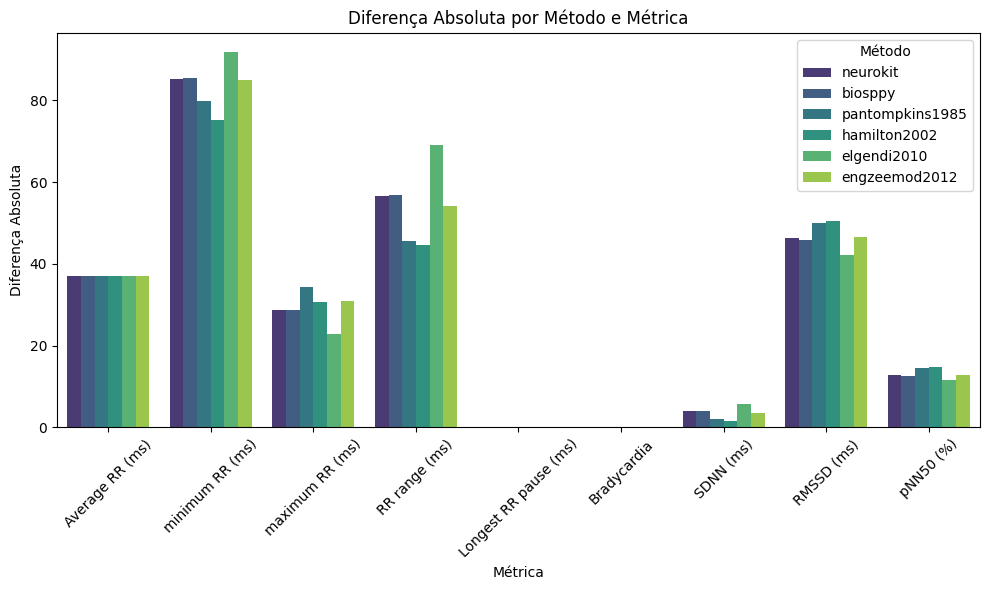

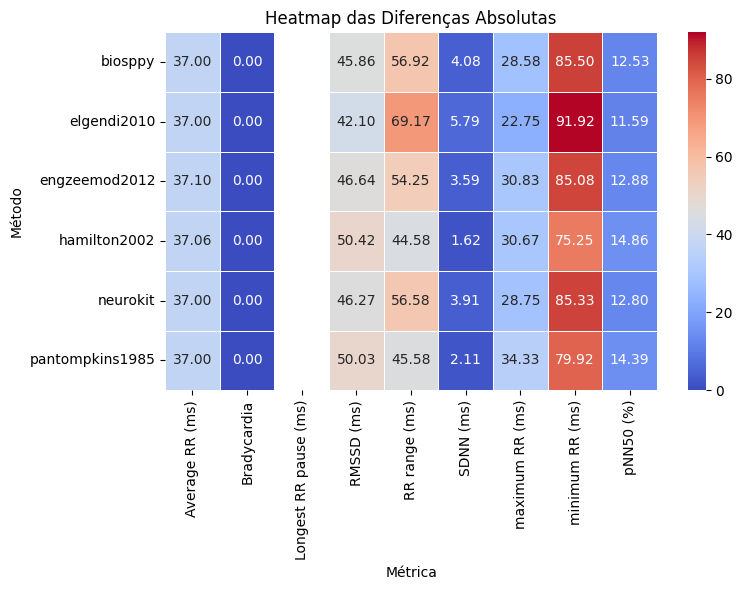

,Métrica,Método,Média,Média sem outliers,Média dos outliers,Desvio Padrão,Nulos,Valor Real,Diferença Absoluta
0,Average RR (ms),neurokit,602.998303,602.998303,nan,64.966070,0,566.000000,36.998303
1,Average RR (ms),biosppy,603.001554,603.001554,nan,64.963865,0,566.000000,37.001554
2,Average RR (ms),pantompkins1985,603.002237,603.002237,nan,64.971074,0,566.000000,37.002237
3,Average RR (ms),hamilton2002,603.060839,603.060839,nan,64.983560,0,566.000000,37.060839
4,Average RR (ms),elgendi2010,603.000383,603.000383,nan,64.947997,0,566.000000,37.000383
5,Average RR (ms),engzeemod2012,603.104212,603.104212,nan,64.988883,0,566.000000,37.104212
6,minimum RR (ms),neurokit,511.333333,491.698113,660.000000,60.456362,0,426.000000,85.333333
7,minimum RR (ms),biosppy,511.500000,491.886792,660.000000,61.038332,0,426.000000,85.500000
8,minimum RR (ms),pantompkins1985,505.916667,485.754717,658.571429,61.115975,0,426.000000,79.916667
9,minimum RR (ms),hamilton2002,501.250000,477.692308,654.375000,65.617181,0,426.000000,75.250000


In [192]:
avaliacaometricas(results_df, real)


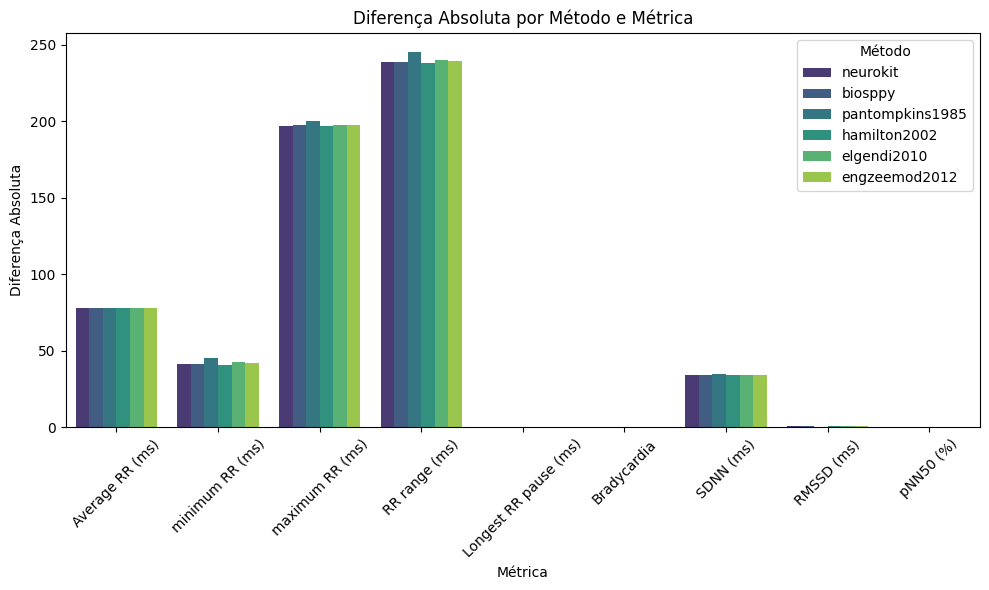

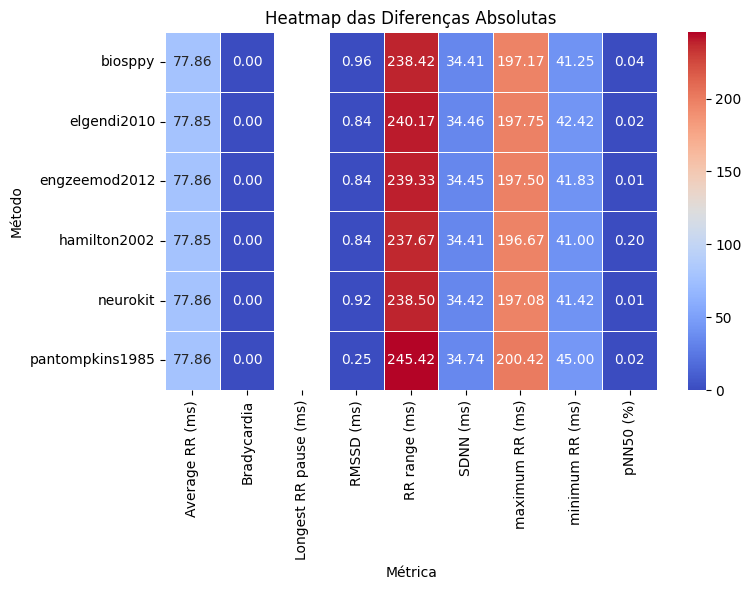

,Métrica,Método,Média,Média sem outliers,Média dos outliers,Desvio Padrão,Nulos,Valor Real,Diferença Absoluta
0,Average RR (ms),neurokit,488.141982,488.141982,nan,19.997020,0,566.000000,77.858018
1,Average RR (ms),biosppy,488.142536,488.142536,nan,19.993047,0,566.000000,77.857464
2,Average RR (ms),pantompkins1985,488.144347,488.144347,nan,19.993183,0,566.000000,77.855653
3,Average RR (ms),hamilton2002,488.147873,488.147873,nan,19.991561,0,566.000000,77.852127
4,Average RR (ms),elgendi2010,488.148410,488.148410,nan,19.989587,0,566.000000,77.851590
5,Average RR (ms),engzeemod2012,488.142896,488.142896,nan,19.991879,0,566.000000,77.857104
6,minimum RR (ms),neurokit,467.416667,472.500000,320.000000,33.261823,0,426.000000,41.416667
7,minimum RR (ms),biosppy,467.250000,472.327586,320.000000,33.248232,0,426.000000,41.250000
8,minimum RR (ms),pantompkins1985,471.000000,472.033898,410.000000,20.477354,0,426.000000,45.000000
9,minimum RR (ms),hamilton2002,467.000000,467.000000,nan,25.264700,0,426.000000,41.000000


In [174]:
avaliacaometricas(results_df, real)

In [ ]:

%%time

import logging
from tqdm import tqdm
import duckdb

# Conexões separadas
conn_leitura = duckdb.connect("D:/Projeto_Tese_mestrado/02_Dataset/Duckedb/Holter_ECG/1h/banco_ecg.duckdb")



# # Lista de pacientes únicos
# lista = conn_leitura.execute("""
#     SELECT DISTINCT id_paciente FROM ecg_pacientes ORDER BY id_paciente;
# """).fetchdf()

# Seleciona 5 pacientes a partir da posição 10 (ou seja, índices 10 a 14)
lista = conn_leitura.execute("""
    SELECT DISTINCT id_paciente 
    FROM ecg_pacientes 
    ORDER BY id_paciente 
    LIMIT 5 OFFSET 10;
""").fetchdf()


# Logging configurado
logging.basicConfig(filename='processamento_ecg.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Processar pacientes
for paciente in tqdm(lista['id_paciente'], desc="Processando pacientes", unit="paciente"):

    # Consulta dados do paciente
    df = conn_leitura.execute(f"""
        SELECT * FROM ecg_pacientes
        WHERE id_paciente = '{paciente}';
    """).fetchdf()

    # Sinal
    ecg_x = df['sinal_x'].values

    # Processamento
    atributos = ECGProcessor()
    variavel = atributos.process(ecg_x, sampling_rate=200)
    
    # Adicionar colunas extras
    variavel['id_paciente'] = paciente
    


    # Limpar memória
    del ecg_x

NameError: name 'lista' is not defined

## 2 Teste de validação

| Função         | Objetivo                                              | Usada para...                                                   |
| -------------- | ----------------------------------------------------- | --------------------------------------------------------------- |
| ecg_clean      | Limpeza especializada de ECG para detecção de picos R | Pré-processamento antes de ecg_peaks ou ecg_process.            |
| signal_filter  | Filtragem geral de qualquer sinal (não só ECG)        | Personalizar filtros: por exemplo, rejeitar ruído de linha ou suavizar sinal. |


In [ ]:
import time
class ECGProcessor_02etapa:

    def __init__(self, fs=200):
        
        self.fs = fs
        self.id_paciente = None  # ID do paciente, se necessário
        
        
    def epocas(self,signal):
        """
        Divide o sinal de ECG limpo em épocas de 60 segundos.
        """
        
        epoch_duration_seconds = 60  # Duração de cada época em segundos
        epoch_length_samples = epoch_duration_seconds * self.fs  # Tamanho da época em amostras

        # Número total de épocas que cabem no sinal
        num_epochs = len(signal) // epoch_length_samples

        # Eventos (índices de início de cada época)
        events = [i * epoch_length_samples for i in range(num_epochs)]

        # Criação das épocas usando o NeuroKit
        epochs = nk.epochs_create(signal,
                                  events=events,
                                  sampling_rate=self.fs,
                                  epochs_start=0,
                                  epochs_end=60)
        return epochs



    def qts(self,sinal):
        """
        Calcula duas medidas para cada época:
        - Duração média do complexo QRS (QRS Duration)
        - Intervalo QT corrigido (QTc), usando a fórmula de Bazett
        """
        #epochs = self.epocas()

        qrs_duration_media = []
        qt_interval_media = []
        HRV_MeanNN = []
        HRV_rmSSD = []
        #epoca = []

        # for x in range(1, 61):
        #     sinal = epochs[f'{x}']['Signal'].values

        # Detecção dos picos R no sinal
        peaks, info = nk.ecg_peaks(sinal, sampling_rate=self.fs)
        
        # Verifica se há batimentos detectados
        if len(info["ECG_R_Peaks"]) == 0:
            print(f"Nenhum R-peak detectado para o paciente {self.id_paciente}. Pulando cálculo do QRS/QT.")
            #continue  # Pula para a próxima época
            
        
        
        #==========================================calculo HRV==================================
        """
        Calcula duas métricas de variabilidade da frequência cardíaca (HRV) para cada época:
        - HRV_MeanNN: média dos intervalos NN
        - HRV_RMSSD: raiz quadrada da média dos quadrados das diferenças sucessivas entre intervalos NN
        """
            
        
        hrv_time = nk.hrv_time(peaks, sampling_rate=self.fs, show=False)  # Calcula HRV

        HRV_MeanNN.append(hrv_time['HRV_MeanNN'].values[0])   
        HRV_rmSSD.append(hrv_time['HRV_RMSSD'].values[0]) 
        # epoca.append(x)  # Número da época
        
        
        #==========================================calculo dos QTs==================================
    
        # Delineamento das ondas (P, QRS, T) com a transformada wavelet
        delineate, _ = nk.ecg_delineate(sinal, rpeaks=info["ECG_R_Peaks"],
                                        sampling_rate=self.fs, method="dwt")

        # Índices dos picos relevantes
        q_peaks = delineate[delineate["ECG_Q_Peaks"] == 1].index.to_numpy()
        s_peaks = delineate[delineate["ECG_S_Peaks"] == 1].index.to_numpy()
        t_offsets = delineate[delineate["ECG_T_Offsets"] == 1].index.to_numpy()

        # Verifica se há pares suficientes para análise
        if len(q_peaks) == 0 or len(s_peaks) == 0 or len(t_offsets) == 0:
            qrs_duration_media.append(np.nan)
            qt_interval_media.append(np.nan)
            #continue

        # Garante que os pares tenham o mesmo tamanho
        min_len_qs = min(len(q_peaks), len(s_peaks))
        min_len_qt = min(len(q_peaks), len(t_offsets))

        q_peaks_qs = q_peaks[:min_len_qs]
        s_peaks_qs = s_peaks[:min_len_qs]
        q_peaks_qt = q_peaks[:min_len_qt]
        t_offsets_qt = t_offsets[:min_len_qt]

        # Seleciona apenas pares válidos (respeitando a ordem no tempo)
        pares_qs = [(q, s) for q, s in zip(q_peaks_qs, s_peaks_qs) if s > q]
        pares_qt = [(q, t) for q, t in zip(q_peaks_qt, t_offsets_qt) if t > q]

        # Cálculo da duração do complexo QRS em milissegundos
        qrs_duration_ms = [(s - q) / self.fs * 1000 for q, s in pares_qs]
        # Cálculo do intervalo QT em milissegundos
        qt_interval_ms = [(t - q) / self.fs * 1000 for q, t in pares_qt]

        # Aplica média apenas se houver pares válidos
        qrs_duration_media.append(np.nanmean(qrs_duration_ms) if len(qrs_duration_ms) > 0 else np.nan)
        qt_interval_media.append(np.nanmean(qt_interval_ms) if len(qt_interval_ms) > 0 else np.nan)

        # Cálculo do intervalo RR médio em segundos
        rr_intervals = np.diff(info["ECG_R_Peaks"]) / self.fs
        rr_medio = np.mean(rr_intervals)

        # Cálculo do QTc (intervalo QT corrigido) usando a fórmula de Bazett
        if len(qt_interval_ms) > 0 and rr_medio > 0:
            qt_c_medio = np.nanmean(qt_interval_ms) / np.sqrt(rr_medio)
        else:
            qt_c_medio = np.nan

        # Substitui o valor do intervalo QT pela versão corrigida (QTc)
        qt_interval_media[-1] = qt_c_medio

        return qrs_duration_media, qt_interval_media, HRV_MeanNN, HRV_rmSSD
        

    def detrend_signal(self, signal, method, **kwargs):
        """
        Detrends the signal using the specified method and parameters.
        
        Parameters:
        - signal: The input signal to be detrended.
        - method: The detrending method to use.
        - kwargs: Additional parameters for the detrending method.
        
        Returns:
        - Detrended signal.
        """
        return nk.signal_detrend(signal, method=method, **kwargs)

    def filter_signal(self, signal, **kwargs):
        """
        Filters the signal using the specified method and parameters.
        
        Parameters:
        - signal: The input signal to be filtered.
        - method: The filtering method to use.
        - kwargs: Additional parameters for the filtering method.
        
        Returns:
        - Filtered signal.
        """
        return nk.signal_filter(signal, sampling_rate=self.fs, **kwargs)
    
    def segundo_processo(self, signal):

        dfs = []

        # Lista de métodos de detrend
        metodos = [
            {"name": "baseline",  "method": "polynomial", "order": 0},
            {"name": "linear",    "method": "polynomial", "order": 1},
            {"name": "quadratic", "method": "polynomial", "order": 2},
            {"name": "cubic",     "method": "polynomial", "order": 3},
            {"name": "poly10",    "method": "polynomial", "order": 10},
            {"name": "tarvainen", "method": "tarvainen2002"},
            {"name": "loess",     "method": "loess"},
            {"name": "locreg",    "method": "locreg", "window": 1.5, "stepsize": 0.02, "sampling_rate": 100},
            {"name": "emd",       "method": "EMD", "components": [-2, -1]}
        ]

        # Lista de filtros
        filtros = [
            {"name": "Butter_2",    "lowcut": 10/60, "highcut": 30/60, "method": "butterworth",    "order": 2},
            {"name": "Butter_2_BA", "lowcut": 10/60, "highcut": 30/60, "method": "butterworth_ba", "order": 2},
            {"name": "Butter_5",    "lowcut": 10/60, "highcut": 30/60, "method": "butterworth",    "order": 5},
            {"name": "Butter_5_BA", "lowcut": 10/60, "highcut": 30/60, "method": "butterworth_ba", "order": 5},
            {"name": "Bessel_2",    "lowcut": 10/60, "highcut": 30/60, "method": "bessel",         "order": 2},
            {"name": "Bessel_5",    "lowcut": 10/60, "highcut": 30/60, "method": "bessel",         "order": 5},
            {"name": "FIR",         "lowcut": 10/60, "highcut": 30/60, "method": "fir"},
            {"name": "Savgol",      "method": "savgol"}
        ]

        # Medir tempo total
        tempo_inicio_total = time.perf_counter()

        # Aplicação dos métodos
        for m in metodos:
            epochs = self.epocas(signal)

            for x in range(1, 61):
                sinal = epochs[f'{x}']['Signal'].values

                tempo_inicio_detrend = time.perf_counter()
                #kwargs = {k: v for k, v in m.items() if k not in ['name']}
                kwargs = {k: v for k, v in m.items() if k not in ["name"]}
                sinal_detrend = self.detrend_signal(sinal, **kwargs)
                tempo_fim_detrend = time.perf_counter()
                tempo_detrend = tempo_fim_detrend - tempo_inicio_detrend

                for f in filtros:
                    tempo_inicio_filtro = time.perf_counter()
                    kwargs = {k: v for k, v in f.items() if k not in ["name"]}
                    sinal_filtrado = self.filter_signal(sinal_detrend, **kwargs)
                    tempo_fim_filtro = time.perf_counter()
                    tempo_filtro = tempo_fim_filtro - tempo_inicio_filtro

                    # Calcular as métricas
                    tempo_inicio_metrica = time.perf_counter()
                    try:
                        qrs, qt, hrv_mean, hrv_rmssd = self.qts(sinal_filtrado)
                    except Exception as e:
                        print(f"Erro no cálculo de métricas: {e}")
                        qrs, qt, hrv_mean, hrv_rmssd = [np.nan], [np.nan], [np.nan], [np.nan]

                    tempo_fim_metrica = time.perf_counter()
                    tempo_metrica = tempo_fim_metrica - tempo_inicio_metrica

                    # Salvar resultados
                    resultado = {
                        "Metodo_Detrend": m['name'],
                        "Filtro": f['name'],
                        "Epoca": x,
                        "QRS_Media": qrs[0] if qrs else np.nan,
                        "QTc_Media": qt[0] if qt else np.nan,
                        "HRV_MeanNN": hrv_mean[0] if hrv_mean else np.nan,
                        "HRV_RMSSD": hrv_rmssd[0] if hrv_rmssd else np.nan,
                        "Tempo_Detrend": tempo_detrend,
                        "Tempo_Filtro": tempo_filtro,
                        "Tempo_Metrica": tempo_metrica
                    }

                    dfs.append(resultado)

        tempo_fim_total = time.perf_counter()
        print(f"Tempo total de processamento: {tempo_fim_total - tempo_inicio_total:.2f} segundos")

        df_resultado = pd.DataFrame(dfs)
        return df_resultado


In [ ]:
# import numpy as np
# import pandas as pd
# import neurokit2 as nk
# import pywt
# import time
# from datetime import datetime
# import traceback

# class ECGProcessor:
#     def __init__(self, fs=200):
#         self.fs = fs  
#         self.id_paciente = None  
#         self.log_entries = []  # Lista para armazenar entradas de log
        
#     def _log(self, level, message, metodo=None, duration=None):
#         """Adiciona entrada ao log"""
#         timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]
#         self.log_entries.append({
#             'timestamp': timestamp,
#             'level': level,
#             'metodo': metodo,
#             'duration_seconds': duration,
#             'message': message
#         })
        
#     def get_log_df(self):
#         """Retorna log como DataFrame"""
#         return pd.DataFrame(self.log_entries)
        
#     def clear_log(self):
#         """Limpa o log"""
#         self.log_entries = []

#     def calculate_metrics(self, sinal_limpo, metodo):
#         """
#         Calcula métricas de ECG para o sinal completo.
#         """
#         start_time = time.time()
        
#         self._log('INFO', f"Calculando métricas para método {metodo}", metodo=metodo)
        
#         try:
#             self._log('DEBUG', f"Processando sinal com {len(sinal_limpo)} amostras", metodo=metodo)
            
#             # Detecção de picos R
#             peaks, info = nk.ecg_peaks(sinal_limpo, sampling_rate=self.fs)
#             r_peaks = info["ECG_R_Peaks"]
            
#             self._log('DEBUG', f"Detectados {len(r_peaks)} picos R", metodo=metodo)
            
#             # Verificação se há picos R suficientes
#             if len(r_peaks) < 2:
#                 self._log('WARNING', f"Poucos R-peaks detectados ({len(r_peaks)})", metodo=metodo)
#                 return self._create_nan_result(metodo)

#             # RR intervals (em ms)
#             rr_intervals = np.diff(r_peaks) * (1000 / self.fs)
            
#             self._log('DEBUG', f"Intervalos RR originais - min: {np.min(rr_intervals):.2f}ms, max: {np.max(rr_intervals):.2f}ms", metodo=metodo)
            
#             # Filtrar intervalos RR muito extremos
#             valid_rr = rr_intervals[(rr_intervals > 100) & (rr_intervals < 2000)]
            
#             if len(valid_rr) == 0:
#                 self._log('WARNING', f"Nenhum intervalo RR válido", metodo=metodo)
#                 return self._create_nan_result(metodo)

#             self._log('DEBUG', f"{len(valid_rr)} intervalos RR válidos de {len(rr_intervals)} totais", metodo=metodo)

#             # Estatísticas RR
#             min_rr = np.min(valid_rr)
#             max_rr = np.max(valid_rr)
#             avg_rr = np.mean(valid_rr)
#             rr_range = max_rr - min_rr

#             # Longest RR pause
#             longest_rr_pause = max_rr

#             # Detecção de Bradicardia
#             avg_heart_rate = 60000 / avg_rr
#             bradycardia = int(avg_heart_rate < 60)

#             # Variabilidade da frequência cardíaca
#             sdnn = np.std(valid_rr, ddof=1)
            
#             # RMSSD
#             if len(valid_rr) > 1:
#                 rmssd = np.sqrt(np.mean(np.diff(valid_rr) ** 2))
#             else:
#                 rmssd = np.nan
            
#             # pNN50
#             if len(valid_rr) > 1:
#                 nn50 = np.sum(np.abs(np.diff(valid_rr)) > 50)
#                 pnn50 = (nn50 / (len(valid_rr) - 1)) * 100
#             else:
#                 pnn50 = 0

#             # Artefato (%)
#             try:
#                 quality = nk.ecg_quality(sinal_limpo, sampling_rate=self.fs)
#                 if hasattr(quality, '__len__'):
#                     artifact_burden = (1 - np.mean(quality)) * 100
#                 else:
#                     artifact_burden = (1 - quality) * 100 if quality < 1 else 0
#             except Exception as quality_error:
#                 self._log('WARNING', f"Erro no cálculo de qualidade: {quality_error}", metodo=metodo)
#                 try:
#                     normalized_signal = (sinal_limpo - np.mean(sinal_limpo)) / np.std(sinal_limpo)
#                     artifacts = np.abs(normalized_signal) > 3
#                     artifact_burden = np.mean(artifacts) * 100
#                 except:
#                     artifact_burden = 0

#             self._log('DEBUG', f"avg_rr={avg_rr:.2f}, sdnn={sdnn:.2f}, rmssd={rmssd:.2f}", metodo=metodo)

#             duration = time.time() - start_time
#             self._log('INFO', f"Cálculo de métricas concluído", metodo=metodo, duration=duration)
            
#             return {
#                 'Metodo': metodo,
#                 'Average RR (ms)': avg_rr,
#                 'minimum RR (ms)': min_rr,
#                 'maximum RR (ms)': max_rr,
#                 'RR range (ms)': rr_range,
#                 'Longest RR pause (ms)': longest_rr_pause,
#                 'Bradycardia': bradycardia,
#                 'SDNN (ms)': sdnn,
#                 'RMSSD (ms)': rmssd,
#                 'pNN50 (%)': pnn50,
#                 'Artifact burden (%)': artifact_burden
#             }

#         except Exception as e:
#             self._log('ERROR', f"Erro no cálculo de métricas: {str(e)}", metodo=metodo)
#             return self._create_nan_result(metodo)
    
#     def _create_nan_result(self, metodo):
#         """Cria resultado com valores NaN quando não é possível processar"""
#         return {
#             'Metodo': metodo,
#             'Average RR (ms)': np.nan,
#             'minimum RR (ms)': np.nan,
#             'maximum RR (ms)': np.nan,
#             'RR range (ms)': np.nan,
#             'Longest RR pause (ms)': np.nan,
#             'Bradycardia': np.nan,
#             'SDNN (ms)': np.nan,
#             'RMSSD (ms)': np.nan,
#             'pNN50 (%)': np.nan,
#             'Artifact burden (%)': np.nan
#         }

#     def wavelet_filter_preservando_qrs(self, signal, wavelet='db6', level=4, atenuacao=0.2):
#         """
#         Aplica filtro wavelet preservando características do complexo QRS.
#         """
#         start_time = time.time()
        
#         if signal.ndim > 1:
#             signal = signal.flatten()
            
#         coeffs = pywt.wavedec(signal, wavelet, level=level)

#         for i in range(3, len(coeffs)):
#             coeffs[i] *= atenuacao

#         ecg_wavelet_filtered = pywt.waverec(coeffs, wavelet)
        
#         if len(ecg_wavelet_filtered) > len(signal):
#             ecg_wavelet_filtered = ecg_wavelet_filtered[:len(signal)]
        
#         duration = time.time() - start_time
#         self._log('INFO', f"Filtro wavelet aplicado", duration=duration)
        
#         return ecg_wavelet_filtered

#     def process(self, signal, **kwargs):
#         """
#         Função principal de processamento.
#         """
#         total_start_time = time.time()
        
#         self._log('INFO', f"Iniciando processamento do sinal: {len(signal)} amostras")
#         self._log('DEBUG', f"Sinal original - média: {np.mean(signal):.6f}, std: {np.std(signal):.6f}")
        
#         metodo = kwargs.get('method')
        
#         if not metodo:
#             self._log('ERROR', "Nenhum método fornecido para processamento.")
#             return pd.DataFrame()
        
#         # Filtro wavelet
#         try:
#             ecg_wavelet_filtered = self.wavelet_filter_preservando_qrs(
#                 signal, wavelet='db6', level=2, atenuacao=0.2
#             )
#             self._log('DEBUG', f"Após filtro wavelet - média: {np.mean(ecg_wavelet_filtered):.6f}, std: {np.std(ecg_wavelet_filtered):.6f}")
#         except Exception as e:
#             self._log('ERROR', f"Erro no filtro wavelet: {e}\n{traceback.format_exc()}")
#             ecg_wavelet_filtered = signal
        
#         method_start_time = time.time()
        
#         try:
#             self._log('INFO', f"Processando método: {metodo}", metodo=metodo)
            
#             # Aplicação do método de limpeza
#             kwargs_filtered = {k: v for k, v in kwargs.items() if k not in ["name", "method"]}
#             ecg_limpo = nk.signal_filter(ecg_wavelet_filtered, sampling_rate=self.fs, **kwargs_filtered)
            
#             self._log('DEBUG', f"Após limpeza - média: {np.mean(ecg_limpo):.6f}, std: {np.std(ecg_limpo):.6f}", metodo=metodo)
            
#             is_different = not np.allclose(ecg_limpo, ecg_wavelet_filtered, rtol=1e-10)
#             self._log('DEBUG', f"Sinal foi modificado pela limpeza: {is_different}", metodo=metodo)
            
#             # Cálculo das métricas
#             result = self.calculate_metrics(ecg_limpo, metodo)
            
#             self._log('INFO', f"Método processado com sucesso", metodo=metodo)
            
#             # Criação do DataFrame
#             df = pd.DataFrame([result])
            
#         except Exception as e:
#             self._log('ERROR', f"Erro no método {metodo}: {str(e)}\n{traceback.format_exc()}", metodo=metodo)
#             return pd.DataFrame()
        
#         method_duration = time.time() - method_start_time
#         self._log('INFO', f"Método {metodo} concluído", metodo=metodo, duration=method_duration)
        
#         # Finalização
#         if not df.empty:
#             self._log('INFO', f"DataFrame final: {len(df)} linhas")
            
#             total_duration = time.time() - total_start_time
#             self._log('INFO', f"Processamento total concluído", duration=total_duration)
            
#             return df
#         else:
#             self._log('ERROR', "Nenhum dado foi processado com sucesso")
#             return pd.DataFrame()

In [ ]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import pywt
import time
from datetime import datetime

class ECGProcessor:
    def __init__(self, fs=200):
        self.fs = fs  
        self.id_paciente = None  
        self.log_entries = []
        
    def _log(self, level, message, metodo=None, duration=None):
        """Log simplificado - apenas erros e info principal"""
        if level in ['ERROR', 'WARNING']:
            timestamp = datetime.now().strftime("%H:%M:%S")
            self.log_entries.append({
                'timestamp': timestamp,
                'level': level,
                'metodo': metodo,
                'message': message
            })
        
    def get_log_df(self):
        return pd.DataFrame(self.log_entries)
        
    def clear_log(self):
        self.log_entries = []

    def calculate_metrics(self, sinal_limpo, metodo):
        """Calcula métricas de ECG otimizado"""
        try:
            # Pré-processamento do sinal para melhor detecção
            if len(sinal_limpo) < 100:  # Sinal muito curto
                self._log('WARNING', f"Sinal muito curto: {len(sinal_limpo)}", metodo=metodo)
                return self._create_nan_result(metodo)
            
            # Normalizar sinal se necessário
            if np.std(sinal_limpo) > 0:
                sinal_normalizado = (sinal_limpo - np.mean(sinal_limpo)) / np.std(sinal_limpo)
            else:
                sinal_normalizado = sinal_limpo
            
            # Detecção de picos R com múltiplos métodos
            try:
                peaks, info = nk.ecg_peaks(sinal_normalizado, sampling_rate=self.fs, method="neurokit")
                r_peaks = info["ECG_R_Peaks"]
            except:
                try:
                    peaks, info = nk.ecg_peaks(sinal_normalizado, sampling_rate=self.fs, method="pantompkins1985")
                    r_peaks = info["ECG_R_Peaks"]
                except:
                    # Fallback: detecção simples por threshold
                    threshold = np.std(sinal_normalizado) * 1.5
                    r_peaks = np.where(sinal_normalizado > threshold)[0]
                    # Filtrar picos muito próximos (< 0.3s)
                    if len(r_peaks) > 1:
                        diff_peaks = np.diff(r_peaks)
                        valid_indices = np.where(diff_peaks > 0.3 * self.fs)[0]
                        r_peaks = r_peaks[np.concatenate(([0], valid_indices + 1))]
            
            if len(r_peaks) < 2:
                self._log('WARNING', f"Poucos R-peaks: {len(r_peaks)} (sinal: {len(sinal_limpo)})", metodo=metodo)
                return self._create_nan_result(metodo)

            # RR intervals com validação mais flexível
            rr_intervals = np.diff(r_peaks) * (1000 / self.fs)
            
            # Filtros adaptativos baseados na mediana
            median_rr = np.median(rr_intervals)
            lower_bound = max(200, median_rr * 0.4)  # Mínimo 200ms ou 40% da mediana
            upper_bound = min(2000, median_rr * 2.5)  # Máximo 2000ms ou 250% da mediana
            
            valid_rr = rr_intervals[(rr_intervals > lower_bound) & (rr_intervals < upper_bound)]
            
            if len(valid_rr) == 0:
                self._log('WARNING', f"Nenhum RR válido (median: {median_rr:.1f}ms)", metodo=metodo)
                return self._create_nan_result(metodo)

            # Cálculos vetorizados
            min_rr = np.min(valid_rr)
            max_rr = np.max(valid_rr)
            avg_rr = np.mean(valid_rr)
            
            # Métricas HRV
            sdnn = np.std(valid_rr, ddof=1)
            rmssd = np.sqrt(np.mean(np.diff(valid_rr) ** 2)) if len(valid_rr) > 1 else np.nan
            
            # pNN50 otimizado
            if len(valid_rr) > 1:
                pnn50 = (np.sum(np.abs(np.diff(valid_rr)) > 50) / (len(valid_rr) - 1)) * 100
            else:
                pnn50 = 0

            # Artifact burden simplificado
            try:
                normalized_signal = (sinal_limpo - np.mean(sinal_limpo)) / np.std(sinal_limpo)
                artifact_burden = np.mean(np.abs(normalized_signal) > 3) * 100
            except:
                artifact_burden = 0
            
            return {
                'Metodo': metodo,
                'Average RR (ms)': avg_rr,
                'minimum RR (ms)': min_rr,
                'maximum RR (ms)': max_rr,
                'RR range (ms)': max_rr - min_rr,
                'Longest RR pause (ms)': max_rr,
                'Bradycardia': int((60000 / avg_rr) < 60),
                'SDNN (ms)': sdnn,
                'RMSSD (ms)': rmssd,
                'pNN50 (%)': pnn50,
                'Artifact burden (%)': artifact_burden
            }

        except Exception as e:
            self._log('ERROR', f"Erro no cálculo: {str(e)}", metodo=metodo)
            return self._create_nan_result(metodo)
    
    def _create_nan_result(self, metodo):
        """Resultado padrão com NaN"""
        return {
            'Metodo': metodo,
            'Average RR (ms)': np.nan,
            'minimum RR (ms)': np.nan,
            'maximum RR (ms)': np.nan,
            'RR range (ms)': np.nan,
            'Longest RR pause (ms)': np.nan,
            'Bradycardia': np.nan,
            'SDNN (ms)': np.nan,
            'RMSSD (ms)': np.nan,
            'pNN50 (%)': np.nan,
            'Artifact burden (%)': np.nan
        }

    def wavelet_filter_preservando_qrs(self, signal, wavelet='db6', level=4, atenuacao=0.2):
        """Filtro wavelet otimizado"""
        if signal.ndim > 1:
            signal = signal.flatten()
            
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        
        # Aplicar atenuação apenas nos coeficientes de alta frequência
        for i in range(3, len(coeffs)):
            coeffs[i] *= atenuacao

        ecg_filtered = pywt.waverec(coeffs, wavelet)
        
        # Ajustar tamanho se necessário
        if len(ecg_filtered) > len(signal):
            ecg_filtered = ecg_filtered[:len(signal)]
        
        return ecg_filtered

    def process(self, signal, **kwargs):
        """Processamento principal otimizado"""
        metodo = kwargs.get('method')
        if not metodo:
            self._log('ERROR', "Método não fornecido")
            return pd.DataFrame()
        
        try:
            # Validação básica do sinal
            if len(signal) < 100 or np.std(signal) == 0:
                self._log('WARNING', f"Sinal inválido: len={len(signal)}, std={np.std(signal):.6f}", metodo=metodo)
                return pd.DataFrame([self._create_nan_result(metodo)])
            
            # Filtro wavelet
            ecg_wavelet_filtered = self.wavelet_filter_preservando_qrs(
                signal, wavelet='db6', level=2, atenuacao=0.2
            )
            
            # Aplicar método de limpeza
            kwargs_filtered = {k: v for k, v in kwargs.items() if k not in ["name", "method"]}
            
            # Tentar aplicar filtro, se falhar usar sinal wavelet
            try:
                ecg_limpo = nk.signal_filter(ecg_wavelet_filtered, sampling_rate=self.fs, **kwargs_filtered)
                # Verificar se o filtro não zerou o sinal
                if np.std(ecg_limpo) == 0:
                    ecg_limpo = ecg_wavelet_filtered
            except:
                ecg_limpo = ecg_wavelet_filtered
                self._log('WARNING', f"Falha no filtro, usando wavelet", metodo=metodo)
            
            # Calcular métricas
            result = self.calculate_metrics(ecg_limpo, metodo)
            
            return pd.DataFrame([result])
            
        except Exception as e:
            self._log('ERROR', f"Erro no processamento: {str(e)}", metodo=metodo)
            return pd.DataFrame([self._create_nan_result(metodo)])

In [224]:
np.array(df['sinal_x']).shape


(720000,)

In [6]:
import pandas as pd
import numpy as np
import neurokit2 as nk

# Criação do processador
processor = ECGProcessor(fs=200)

# Listas de métodos e filtros
metodos = [
    {"name": "baseline",  "method": "polynomial", "order": 0},
    {"name": "linear",    "method": "polynomial", "order": 1},
    #{"name": "quadratic", "method": "polynomial", "order": 2},
    #{"name": "cubic",     "method": "polynomial", "order": 3},
    #{"name": "poly10",    "method": "polynomial", "order": 10},
    #{"name": "tarvainen", "method": "tarvainen2002"},
    #{"name": "loess",     "method": "loess"},
    #{"name": "locreg",    "method": "locreg", "window": 1.5, "stepsize": 0.02, "sampling_rate": 100},
    #{"name": "emd",       "method": "EMD", "components": [-2, -1]}
]

filtros = [
    {"name": "Butter_2",    "lowcut": 10/60, "highcut": 30/60, "method": "butterworth",    "order": 2},
    {"name": "Butter_2_BA", "lowcut": 10/60, "highcut": 30/60, "method": "butterworth_ba", "order": 2},
    #{"name": "Butter_5",    "lowcut": 10/60, "highcut": 30/60, "method": "butterworth",    "order": 5},
    #{"name": "Butter_5_BA", "lowcut": 10/60, "highcut": 30/60, "method": "butterworth_ba", "order": 5},
    #{"name": "Bessel_2",    "lowcut": 10/60, "highcut": 30/60, "method": "bessel",         "order": 2},
    #{"name": "Bessel_5",    "lowcut": 10/60, "highcut": 30/60, "method": "bessel",         "order": 5},
    #{"name": "FIR",         "lowcut": 10/60, "highcut": 30/60, "method": "fir"},
    #{"name": "Savgol",      "method": "savgol"}
]

def epocas(signal):
    """
    Divide o sinal de ECG limpo em épocas de 60 segundos.
    """
    epoch_duration_seconds = 60  # Duração de cada época em segundos
    epoch_length_samples = epoch_duration_seconds * 200  # Tamanho da época em amostras

    # Número total de épocas que cabem no sinal
    num_epochs = len(signal) // epoch_length_samples

    # Eventos (índices de início de cada época)
    events = [i * epoch_length_samples for i in range(num_epochs)]

    # Criação das épocas usando o NeuroKit
    epochs = nk.epochs_create(signal,
                              events=events,
                              sampling_rate=200,
                              epochs_start=0,
                              epochs_end=60)
    return epochs

# Lista para armazenar todos os DataFrames
todos_resultados = []

# Loop sobre cada método de detrend
for metodo in metodos:
    detrend_name = metodo["name"]
    # Remove 'name' para passar apenas os parâmetros
    kwargs_detrend = {k: v for k, v in metodo.items() if k != 'name'}
    
    # Loop sobre cada época (1 a 60)
    for x in range(1, 61):
        
        epochs = epocas(np.array(df['sinal_x']))
        
        # Verifica se a época existe
        if f'{x}' not in epochs:
            print(f"Época {x} não encontrada. Pulando...")
            continue
            
        sinal = epochs[f'{x}']['Signal'].values
        
        # Aplicar detrend
        try:
            sinal_detrend = nk.signal_detrend(sinal, **kwargs_detrend)
        except Exception as e:
            print(f"Erro no detrend {detrend_name} para época {x}: {e}")
            continue
        
        # Loop sobre cada filtro
        for filtro in filtros:
            filter_name = filtro["name"]
            kwargs_filtro = {k: v for k, v in filtro.items() if k != 'name'}
            
            try:
                # Processar o sinal
                resultado = processor.process(
                    sinal_detrend,
                    **kwargs_filtro  # Aqui NÃO inclui 'name'
                )
                
                # Se o resultado não for vazio
                if not resultado.empty:
                    # Adiciona colunas de identificação
                    resultado['Epoca'] = x  # NOVA COLUNA DE ÉPOCA
                    resultado['Detrend'] = detrend_name
                    resultado['Filter'] = filter_name
                    # Adiciona aos resultados
                    todos_resultados.append(resultado)
                    
            except Exception as e:
                print(f"Erro no processamento - Época: {x}, Detrend: {detrend_name}, Filter: {filter_name}: {e}")
                continue

# Concatena todos os resultados em um único DataFrame
if todos_resultados:
    df_final = pd.concat(todos_resultados, ignore_index=True)
    
    # Reordena as colunas para colocar identificadores no início
    colunas_id = ['Epoca', 'Detrend', 'Filter', 'Metodo']
    outras_colunas = [col for col in df_final.columns if col not in colunas_id]
    df_final = df_final[colunas_id + outras_colunas]
    
    # Exibe a forma final
    print(f"DataFrame final com {df_final.shape[0]} linhas e {df_final.shape[1]} colunas.")
    print(f"Épocas processadas: {sorted(df_final['Epoca'].unique())}")
    print(f"Número total de combinações: {len(metodos)} detrends × {len(filtros)} filtros × {df_final['Epoca'].nunique()} épocas = {len(metodos) * len(filtros) * df_final['Epoca'].nunique()}")
    
    # Mostra uma amostra dos dados
    print("\nPrimeiras linhas do DataFrame:")
    print(df_final.head())
    
else:
    print("Nenhum resultado foi processado com sucesso.")
    df_final = pd.DataFrame()

DataFrame final com 240 linhas e 14 colunas.
Épocas processadas: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Número total de combinações: 2 detrends × 2 filtros × 60 épocas = 240

Primeiras linhas do DataFrame:
   Epoca   Detrend       Filter          Metodo  Average RR (ms)  \
0      1  baseline     Butter_2     butterworth              NaN   
1      1  baseline  Butter_2_BA  butterworth_ba              NaN   
2      2  baseline     Butter_2     butterworth              NaN   
3      2  baseline  Butter_2_BA  butterworth_ba              NaN   
4      3  baseline     Butter_2     butterworth              NaN   

   minimum RR (ms)  maximum RR (ms)  RR range (ms)  Longest RR pause (ms)  \
0              NaN              NaN            NaN                    NaN   
1              NaN              NaN   

In [7]:
df_final

,Epoca,Detrend,Filter,Metodo,Average RR (ms),minimum RR (ms),maximum RR (ms),RR range (ms),Longest RR pause (ms),Bradycardia,SDNN (ms),RMSSD (ms),pNN50 (%),Artifact burden (%)
0,1,baseline,Butter_2,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline,Butter_2_BA,butterworth_ba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,baseline,Butter_2,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,baseline,Butter_2_BA,butterworth_ba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,baseline,Butter_2,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,58,linear,Butter_2_BA,butterworth_ba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,59,linear,Butter_2,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,59,linear,Butter_2_BA,butterworth_ba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,60,linear,Butter_2,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [221]:
results_df

,Epoca,Metodo,Average RR (ms),minimum RR (ms),maximum RR (ms),RR range (ms),Longest RR pause (ms),Bradycardia,SDNN (ms),RMSSD (ms),pNN50 (%),Artifact burden (%)
0,1,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,butterworth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [222]:
log_df

,timestamp,level,epoca,metodo,duration_seconds,message
0,2025-06-03 22:39:04.668,INFO,NaN,None,NaN,Iniciando processamento do sinal: 720000 amostras
1,2025-06-03 22:39:04.675,DEBUG,NaN,None,NaN,"Sinal original - média: -0.157580, std: 1.164725"
2,2025-06-03 22:39:04.702,INFO,NaN,None,0.027692,Filtro wavelet aplicado
3,2025-06-03 22:39:04.708,DEBUG,NaN,None,NaN,"Após filtro wavelet - média: -0.157580, std: 1..."
4,2025-06-03 22:39:04.708,INFO,NaN,butterworth,NaN,Processando método: butterworth
...,...,...,...,...,...,...
200,2025-06-03 22:39:05.591,INFO,NaN,butterworth,0.883038,Método butterworth concluído
201,2025-06-03 22:39:05.591,INFO,NaN,None,NaN,DataFrame final: 60 linhas
202,2025-06-03 22:39:05.592,DEBUG,NaN,None,NaN,Average RR único valores: 0
203,2025-06-03 22:39:05.593,DEBUG,NaN,None,NaN,SDNN único valores: 0


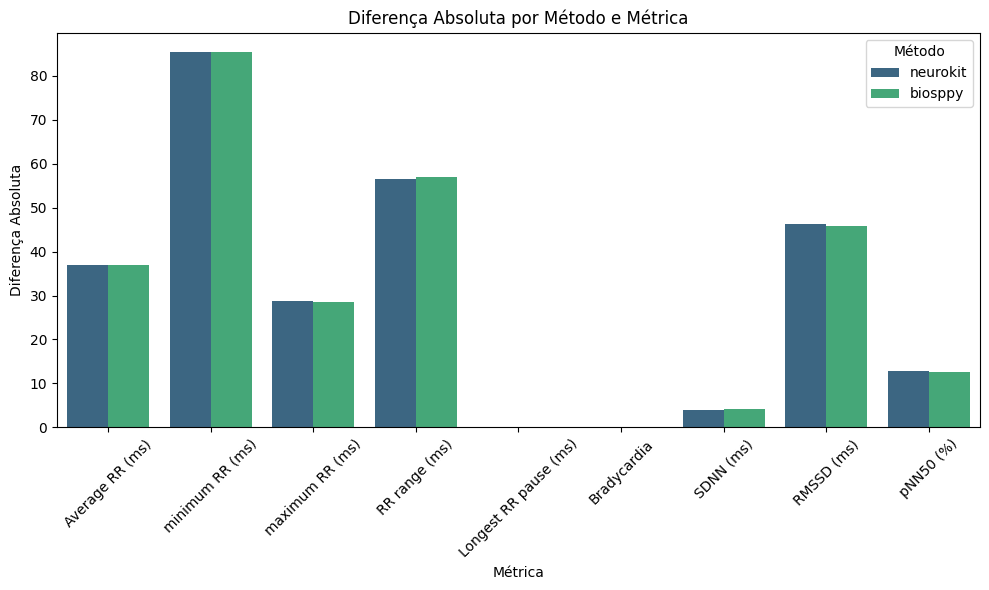

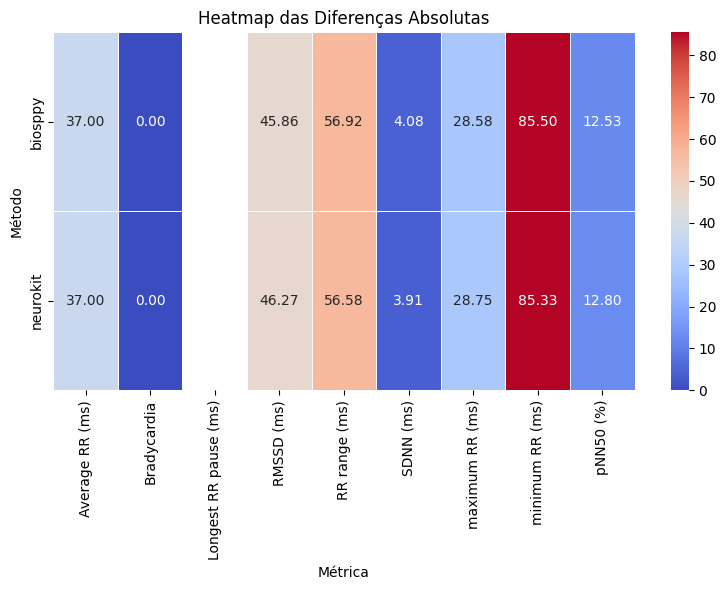

,Métrica,Método,Média,Média sem outliers,Média dos outliers,Desvio Padrão,Nulos,Valor Real,Diferença Absoluta
0,Average RR (ms),neurokit,602.998303,602.998303,nan,64.966070,0,566.000000,36.998303
1,Average RR (ms),biosppy,603.001554,603.001554,nan,64.963865,0,566.000000,37.001554
2,minimum RR (ms),neurokit,511.333333,491.698113,660.000000,60.456362,0,426.000000,85.333333
3,minimum RR (ms),biosppy,511.500000,491.886792,660.000000,61.038332,0,426.000000,85.500000
4,maximum RR (ms),neurokit,734.750000,734.750000,nan,110.960464,0,706.000000,28.750000
5,maximum RR (ms),biosppy,734.583333,734.583333,nan,110.239691,0,706.000000,28.583333
6,RR range (ms),neurokit,223.416667,207.982456,516.666667,116.173058,0,280.000000,56.583333
7,RR range (ms),biosppy,223.083333,207.894737,511.666667,115.296566,0,280.000000,56.916667
8,Longest RR pause (ms),neurokit,734.750000,734.750000,nan,110.960464,0,nan,nan
9,Longest RR pause (ms),biosppy,734.583333,734.583333,nan,110.239691,0,nan,nan


In [ ]:
avaliacaometricas(df_final, real)

In [ ]:
# # Define a new function
# def my_processing(ecg_signal):
#     # Do processing
#     ecg_cleaned = my_cleaning(ecg_signal, sampling_rate=1000)
#     instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
#     rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
#     quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)

#     # Prepare output
#     signals = pd.DataFrame({"ECG_Raw": ecg_signal,
#                             "ECG_Clean": ecg_cleaned,
#                             "ECG_Rate": rate,
#                             "ECG_Quality": quality})

#     signals = pd.concat([signals, instant_peaks], axis=1)

#     # Create info dict
#     info = rpeaks
#     info["sampling_rate"] = 1000
    
#     return signals, info





#    def segundo_processo(self,signal):
        dfs = []
        # 1 Etapa: Detrend do Sinal

        # Apply detrending algorithms
        # ---------------------------
        # Method 1: Default Polynomial Detrending of a Given Order
        # Lista de métodos e parâmetros
        metodos = [
            {"name": "baseline",  "method": "polynomial", "order": 0}, # Constant detrend (removes the mean)
            {"name": "linear",    "method": "polynomial", "order": 1}, # Linear Detrend (removes the linear trend)
            # Polynomial Detrend (removes the polynomial trend)
            {"name": "quadratic", "method": "polynomial", "order": 2}, # Quadratic detrend
            {"name": "cubic",     "method": "polynomial", "order": 3}, # Cubic detrend
            {"name": "poly10",    "method": "polynomial", "order": 10}, # Linear detrend (10th order)
            {"name": "tarvainen", "method": "tarvainen2002"}, # Method 2: Tarvainen's smoothness priors approach (Tarvainen et al., 2002)
            {"name": "loess",     "method": "loess"}, # Method 3: LOESS smoothing trend removal
            {"name": "locreg",    "method": "locreg", "window": 1.5, "stepsize": 0.02, "sampling_rate": 100}, # Method 4: Local linear regression (100Hz)
            {"name": "emd",       "method": "EMD",    "components": [-2, -1]}  # Method 5: EMD
        ]
        
         # Lista de métodos de filtro e parâmetros
        filtros = [
                {"name": "Butter_2",    "lowcut": 10/60, "highcut": 30/60, "method": "butterworth",    "order": 2},
                {"name": "Butter_2_BA", "lowcut": 10/60, "highcut": 30/60, "method": "butterworth_ba", "order": 2},
                {"name": "Butter_5",    "lowcut": 10/60, "highcut": 30/60, "method": "butterworth",    "order": 5},
                {"name": "Butter_5_BA", "lowcut": 10/60, "highcut": 30/60, "method": "butterworth_ba", "order": 5},
                {"name": "Bessel_2",    "lowcut": 10/60, "highcut": 30/60, "method": "bessel",         "order": 2},
                {"name": "Bessel_5",    "lowcut": 10/60, "highcut": 30/60, "method": "bessel",         "order": 5},
                {"name": "FIR",         "lowcut": 10/60, "highcut": 30/60, "method": "fir"},
                {"name": "Savgol",      "method": "savgol"}
            ]
        
        # Medir tempo total
        tempo_inicio_total = time.perf_counter()

        # Aplicação dos métodos
        for m in metodos:
            
            
            epochs = self.epocas(signal)
            for x in range(1, 61):
                # 1 Etapa: Detrend do Sinal
                
                
                sinal = epochs[f'{x}']['Signal'].values
                
                tempo_inicio_detrend = time.perf_counter()
                # Remove 'name' antes de passar como kwargs
                kwargs = {k: v for k, v in m.items() if k not in ["name", "method"]}
                
                
                detrended = self.detrend_signal(sinal, m["method"], **kwargs)
                
                tempo_fim_detrend = time.perf_counter()
                print(f"[{m['name']}] Tempo para detrend: {tempo_fim_detrend - tempo_inicio_detrend:.4f} segundos")

                # 2 Etapa: Aplicação de Filtros

                # Lista de métodos de filtro e parâmetros
                # Aplicação dos filtros
                for f in filtros:
                    
                    tempo_inicio_filtro = time.perf_counter()
                    
                    # Remove 'name' antes de passar como kwargs
                    kwargs = {k: v for k, v in f.items() if k not in ["name"]}
                    
                    # Aplica o filtro ao sinal já detrended
                    ecg_filtrado = self.filter_signal(detrended, **kwargs)
                    
                    tempo_fim_filtro = time.perf_counter()
                    print(f"[{m['name']} + {f['name']}] Tempo para filtro: {tempo_fim_filtro - tempo_inicio_filtro:.4f} segundos")

                
                    tempo_inicio_qts = time.perf_counter()
                    # Cálculo das métricas QRS de QTc e HRV
                    qrs_duration_media, qt_interval_media, HRV_MeanNN, HRV_rmSSD = self.qts(ecg_filtrado)
                    tempo_fim_qts = time.perf_counter()
                    print(f"[{m['name']} + {f['name']}] Tempo para qts: {tempo_fim_qts - tempo_inicio_qts:.4f} segundos")

                    
                    # Cálculo das métricas QRS de QTc e HRV
                    df = pd.DataFrame({
                        'Metodo_Detrend': m['name'],
                        'Metodo_Filtro': f['name'],
                        'Epoca': x,
                        'HRV_MeanNN': HRV_MeanNN,
                        'HRV_rmSSD': HRV_rmSSD,
                        'QRS_Duration': qrs_duration_media,
                        'QT_Interval': qt_interval_media
                    })

                dfs.append(df)

        tempo_fim_total = time.perf_counter()
        print(f"Tempo total de processamento: {tempo_fim_total - tempo_inicio_total:.4f} segundos")

        return pd.concat(dfs, ignore_index=True)
        

